# Capstone Practicum

Force mount your google drive (if running on colab) else comment those lines.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install imbalanced-learn

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.8 MB/s eta 0:00:00


Import the necessary libraries and modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import silhouette_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
  # Get the CUDA version PyTorch is built with
  print("CUDA Version:", torch.version.cuda)

Using device: cpu


Load the required file path (either from google drive or from desktop as required) and print the first few columns using head() function after removing all data for the year 2024.

In [4]:
# Load the data
# file_path = r"C:\Users\trupt\OneDrive - Clark University\Sem 3\Capstone Practicum\Alzheimers\investigator_nacc66.csv"
file_path = "/content/drive/MyDrive/Capstone/investigator_nacc66.csv"
data = pd.read_csv(file_path)
df = data[data['VISITYR'] != 2024]
df_unseen = data[data['VISITYR'] == 2024]
print(df.head())

       NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  NACCVNUM  \
0  NACC002909      186      I      3.0       12        28     2022         1   
2  NACC003487      186      I      3.0       11        15     2023         1   
3  NACC004352      186      I      3.0       10         5     2021         1   
4  NACC004687      186      I      3.0       11        14     2022         1   
5  NACC007213      186      I      3.0        5        24     2023         1   

   NACCAVST  NACCNVST  ...  NPATGAM1  NPATGAM2  NPATGAM3  NPATGAM4  NPATGAM5  \
0         2         2  ...        -4        -4        -4        -4        -4   
2         1         1  ...        -4        -4        -4        -4        -4   
3         1         1  ...        -4        -4        -4        -4        -4   
4         1         1  ...        -4        -4        -4        -4        -4   
5         1         1  ...        -4        -4        -4        -4        -4   

   NPATGFRN  NPATGFR1  NPATGFR2  NPATG

### Exploratory Data Analysis

In [5]:
print("Size of Original Dataset: ", df.shape)
print("\n\nInformation about the Original dataset: \n")
df.info()
print(f"\nUnique number of patients: ",df['NACCID'].nunique())
print(f"Unique number of Centers : ",df['NACCADC'].nunique())

Size of Original Dataset:  (190415, 1024)


Information about the Original dataset: 

<class 'pandas.core.frame.DataFrame'>
Index: 190415 entries, 0 to 192087
Columns: 1024 entries, NACCID to NPATGFR4
dtypes: float64(135), int64(747), object(142)
memory usage: 1.5+ GB

Unique number of patients:  51440
Unique number of Centers :  46


The ADCs with the highest number of unique patient visits:
    Encoded_ADC  Original_ADC  Unique_Visits
0            2           289           3210
1           26          4967           2782
2           12          2096           2712
3           14          2289           2254
4           38          8646           2132
5           31          6061           2001
6           25          4935           1982
7           28          5452           1851
8           39          8658           1846
9            9          1354           1831


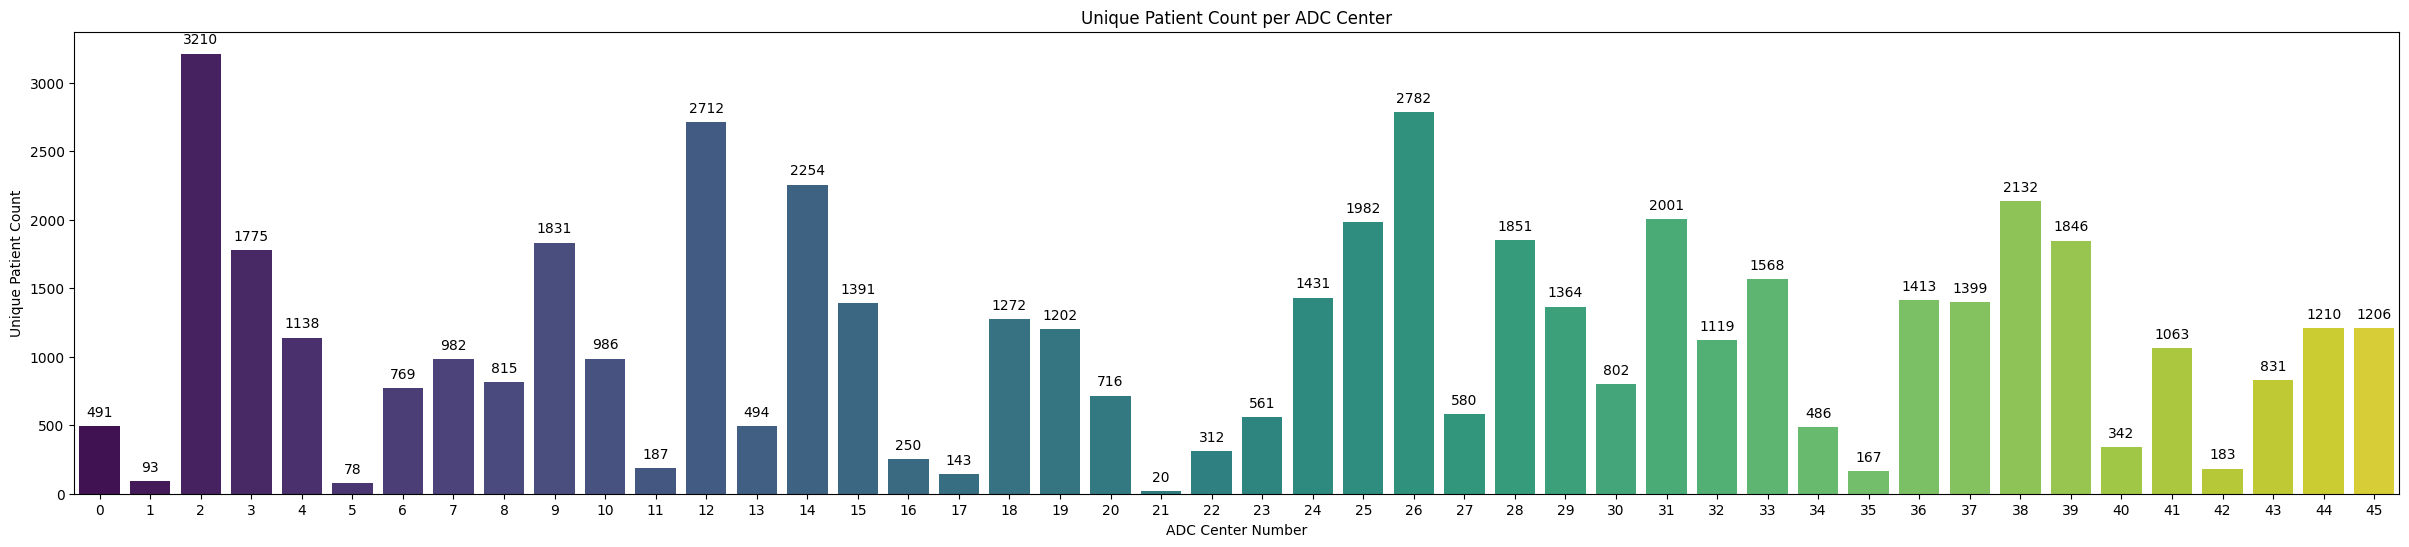

In [6]:
# Step 1: Encode ADC centers into sequential numbers
label_encoder = LabelEncoder()
adc_encoded = label_encoder.fit_transform(df['NACCADC'])
# Step 2: Map encoded ADC back to their original labels
adc_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Step 3: Calculate unique visits (NACCID) per ADC
adc_visits = pd.DataFrame({
    'Encoded_ADC': adc_encoded,
    'NACCADC': df['NACCADC'],
    'NACCID': df['NACCID']
}).groupby('Encoded_ADC')['NACCID'].nunique().sort_values(ascending=False)
# Step 4: Display ADC mapping with visitation counts
adc_visits_mapping = pd.DataFrame({
    'Encoded_ADC': adc_visits.index,
    'Original_ADC': [list(adc_mapping.keys())[list(adc_mapping.values()).index(idx)] for idx in adc_visits.index],
    'Unique_Visits': adc_visits.values
})
print("The ADCs with the highest number of unique patient visits:\n",adc_visits_mapping.head(10))

plt.figure(figsize=(30, 6))
ax = sns.barplot(x=adc_visits_mapping['Encoded_ADC'], y=adc_visits_mapping['Unique_Visits'], palette="viridis")
plt.title('Unique Patient Count per ADC Center')
plt.xlabel('ADC Center Number')
plt.ylabel('Unique Patient Count')
for p in ax.patches:
     ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

SEX
Female    29440
Male      22000
Name: count, dtype: int64


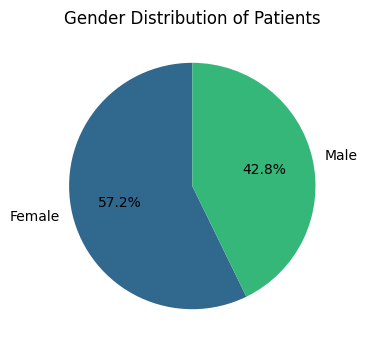

In [7]:
# Map the 'SEX' column values to gender labels
gender_map = {1: 'Male', 2: 'Female'}
# Get the count of unique patients by sex
p_gender = df.drop_duplicates(subset=['NACCID'])['SEX'].map(gender_map).value_counts().sort_index()
print(p_gender)

# Pie chart for gender distribution
plt.figure(figsize=(6, 4))
plt.pie(p_gender.values, labels=p_gender.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(p_gender)), startangle=90)
plt.title('Gender Distribution of Patients')
plt.xlabel('')
plt.ylabel('')
plt.show()

Marital Status Breakdown:

Married: 32482
Widowed: 8238
Divorced: 6018
Seperated: 590
Never married (or marriage was annulled): 2845
Living as married/domestic partner: 847
Other or unknown: 420


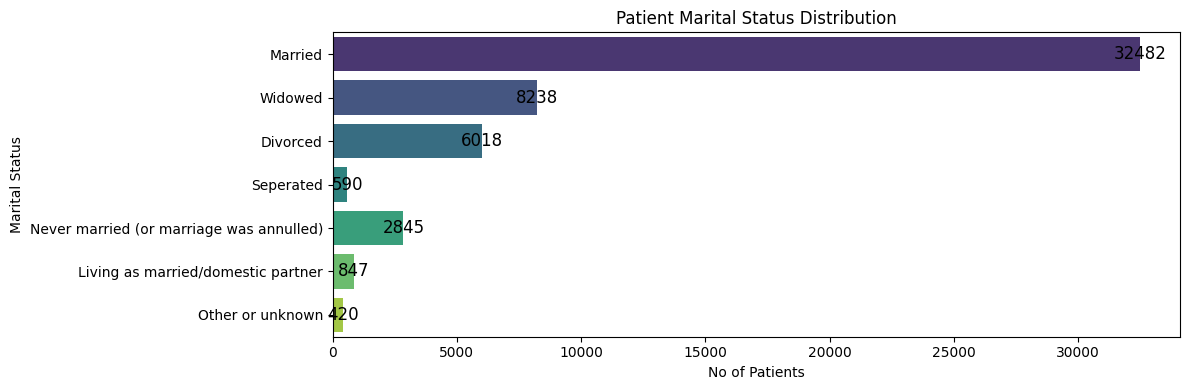

In [8]:
# Marital Status descriptions
m_stat_descriptions = {
    '1': 'Married',
    '2': 'Widowed',
    '3': 'Divorced',
    '4': 'Seperated',
    '5': 'Never married (or marriage was annulled)',
    '6': 'Living as married/domestic partner',
    '9': 'Other or unknown'
}
# Marital Status of patients
m_stat_counts = df.drop_duplicates(subset=['NACCID'])['MARISTAT'].value_counts().sort_index()
print("Marital Status Breakdown:\n")
for key, count in m_stat_counts.items():
    print(f"{m_stat_descriptions.get(str(key))}: {count}")

x_labels = [m_stat_descriptions.get(str(code), "Unknown") for code in m_stat_counts.index]
plt.figure(figsize=(12, 4))
sns.barplot(x=m_stat_counts.values, y=x_labels, palette="viridis")
plt.title('Patient Marital Status Distribution')
plt.xlabel('No of Patients')
plt.ylabel('Marital Status')
for index, value in enumerate(m_stat_counts.values):
    plt.text(value + 2, index, str(value), ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

Visit Type Breakdown:

Follow-up visit: 116599
Initial visit: 50960
Telephone visit: 22376
Telephone Initial visit: 480


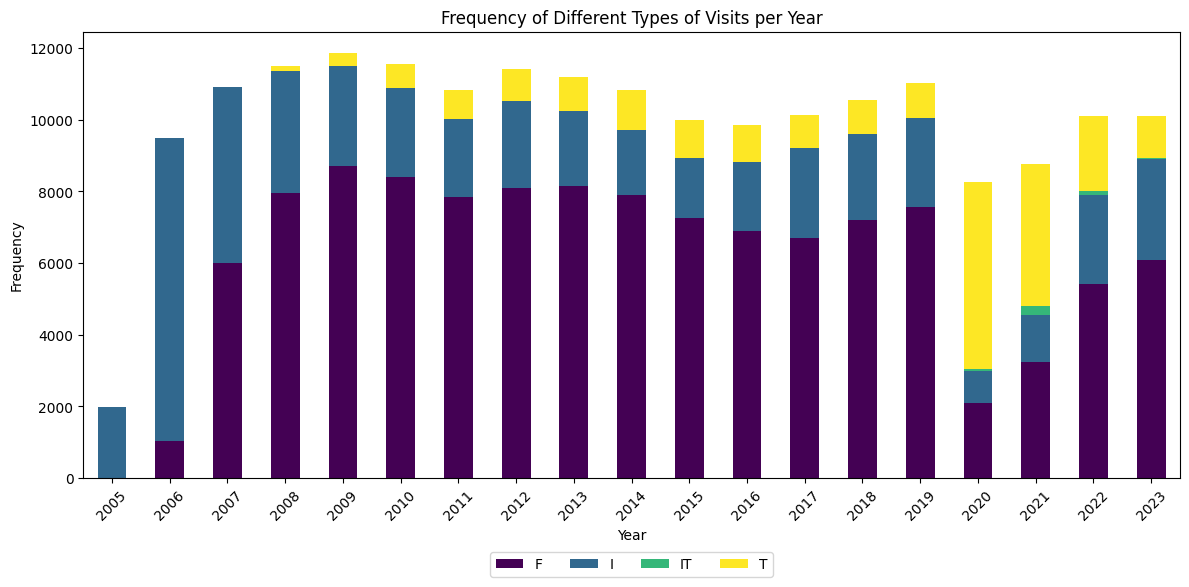

In [9]:
# Define the visit type descriptions
visit_type_descriptions = {
    'I': 'Initial visit',
    'F': 'Follow-up visit',
    'IT': 'Telephone Initial visit',
    'T': 'Telephone visit'
}
# Count the occurrences of each type of visit
visit_type_counts = df['PACKET'].value_counts()
# Print the counts of each visit type
print("Visit Type Breakdown:\n")
for key, count in visit_type_counts.items():
    print(f"{visit_type_descriptions.get(key, key)}: {count}")

# Plot the stacked bar chart with 'viridis' colormap
vt_counts = df.groupby(['VISITYR', 'PACKET']).size().unstack(fill_value=0)
vt_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")
plt.title('Frequency of Different Types of Visits per Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
plt.tight_layout()
plt.show()

Race Breakdown for Demented Patients:

White: 18291
Black or African American: 2211
American Indian or Alaskan Native: 162
Native Hawaiian or other Pacific Islander: 32
Asian: 471
Other (specify): 422
Unknown: 148


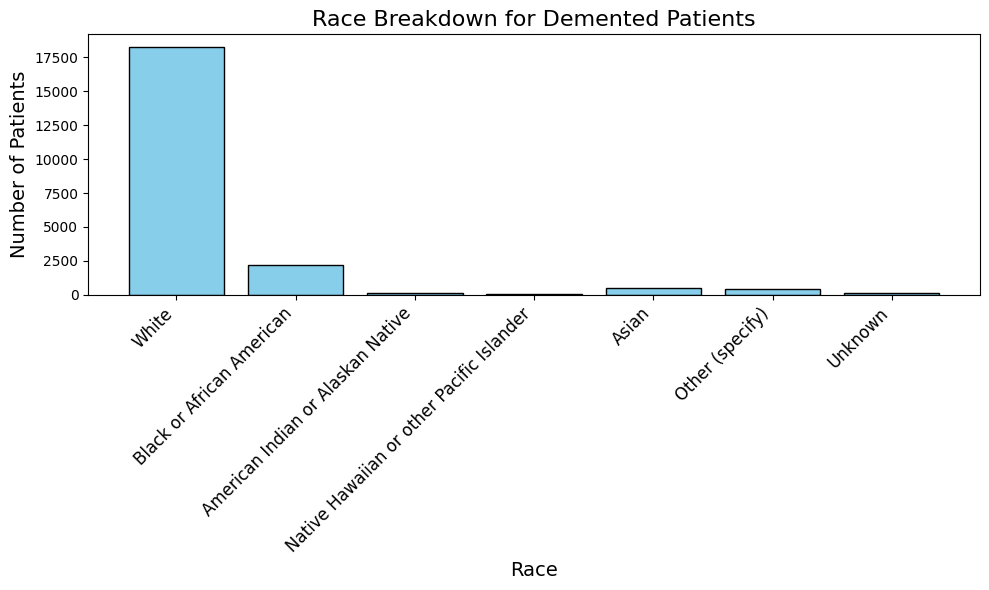

In [10]:
# Racial descriptions
race_descriptions = {
    '1': 'White',
    '2': 'Black or African American',
    '3': 'American Indian or Alaskan Native',
    '4': 'Native Hawaiian or other Pacific Islander',
    '5': 'Asian',
    '50': 'Other (specify)',
    '99': 'Unknown'
}

# Race of patients
demented_df = df[df['DEMENTED'] == 1]
race_counts = demented_df.drop_duplicates(subset=['NACCID'])['RACE'].value_counts().sort_index()
race_labels = [race_descriptions.get(str(key), 'Unknown') for key in race_counts.index]
race_values = race_counts.values
print("Race Breakdown for Demented Patients:\n")
for label, count in zip(race_labels, race_values):
    print(f"{label}: {count}")

# Create a bar chart for the race breakdown
plt.figure(figsize=(10, 6))
plt.bar(race_labels, race_values, color='skyblue', edgecolor='black')
plt.title('Race Breakdown for Demented Patients', fontsize=16)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

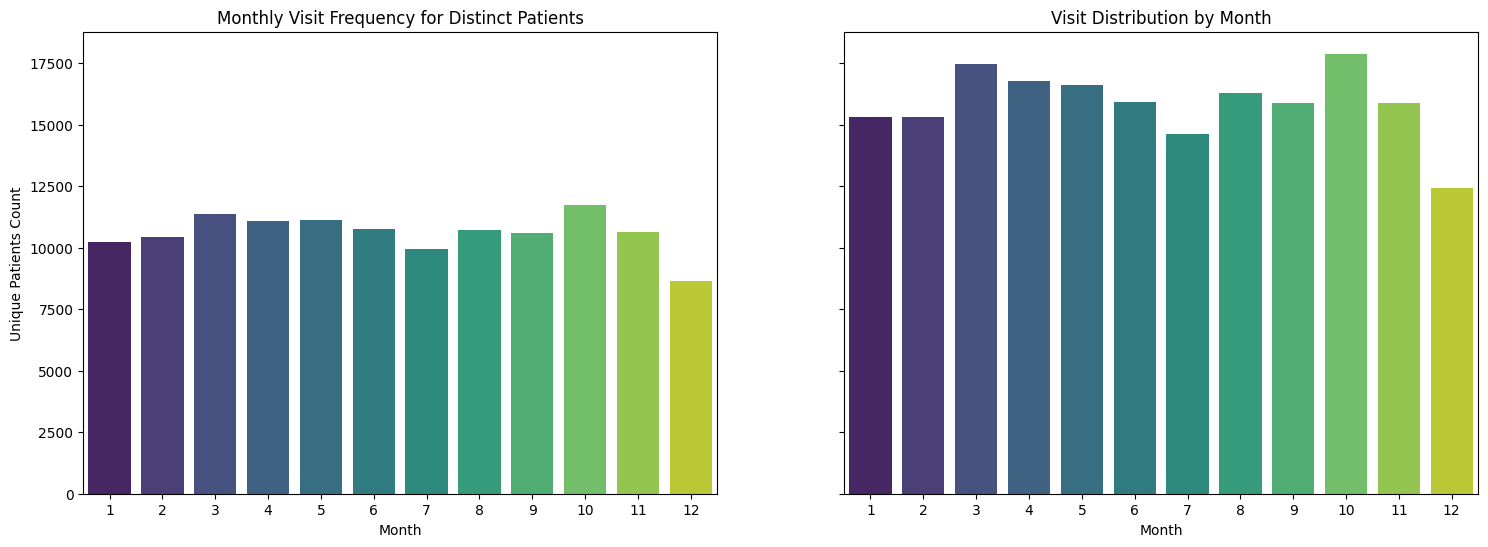

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [11]:
# Unique count of patients for each visit month
unique_visits_per_month = df.groupby('VISITMO')['NACCID'].nunique().sort_index()
# Overall Frequency of Visits per Month
visitmo_counts = df['VISITMO'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=unique_visits_per_month.index, y=unique_visits_per_month.values, palette="viridis", ax=axes[0])
axes[0].set_title('Monthly Visit Frequency for Distinct Patients')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Unique Patients Count')

plt.figure(figsize=(12, 6))
sns.barplot(x=visitmo_counts.index, y=visitmo_counts.values, palette="viridis", ax=axes[1])
axes[1].set_title('Visit Distribution by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

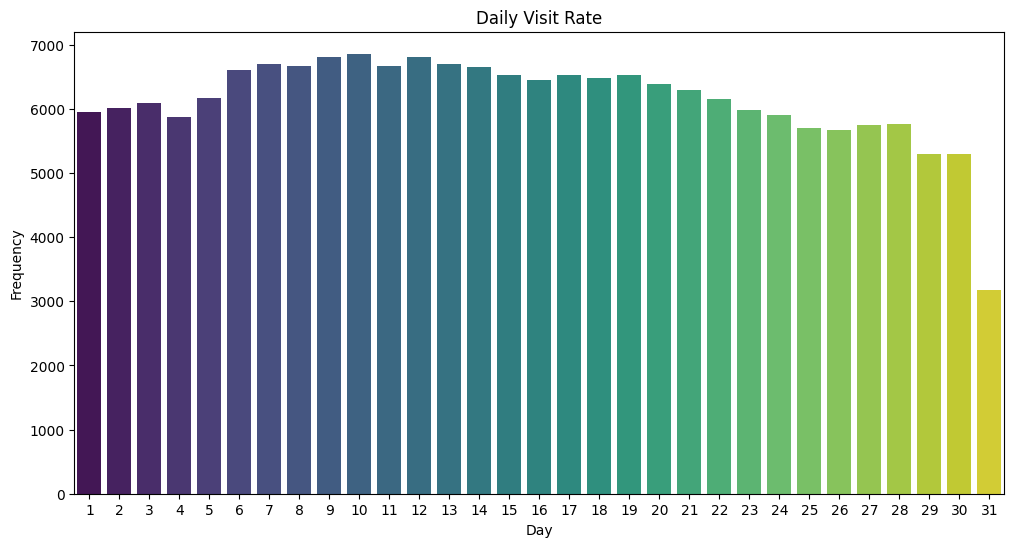

In [12]:
# Overall Frequency of Visits per day
visitday_counts = df['VISITDAY'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=visitday_counts.index, y=visitday_counts.values, palette="viridis")
plt.title('Daily Visit Rate')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()

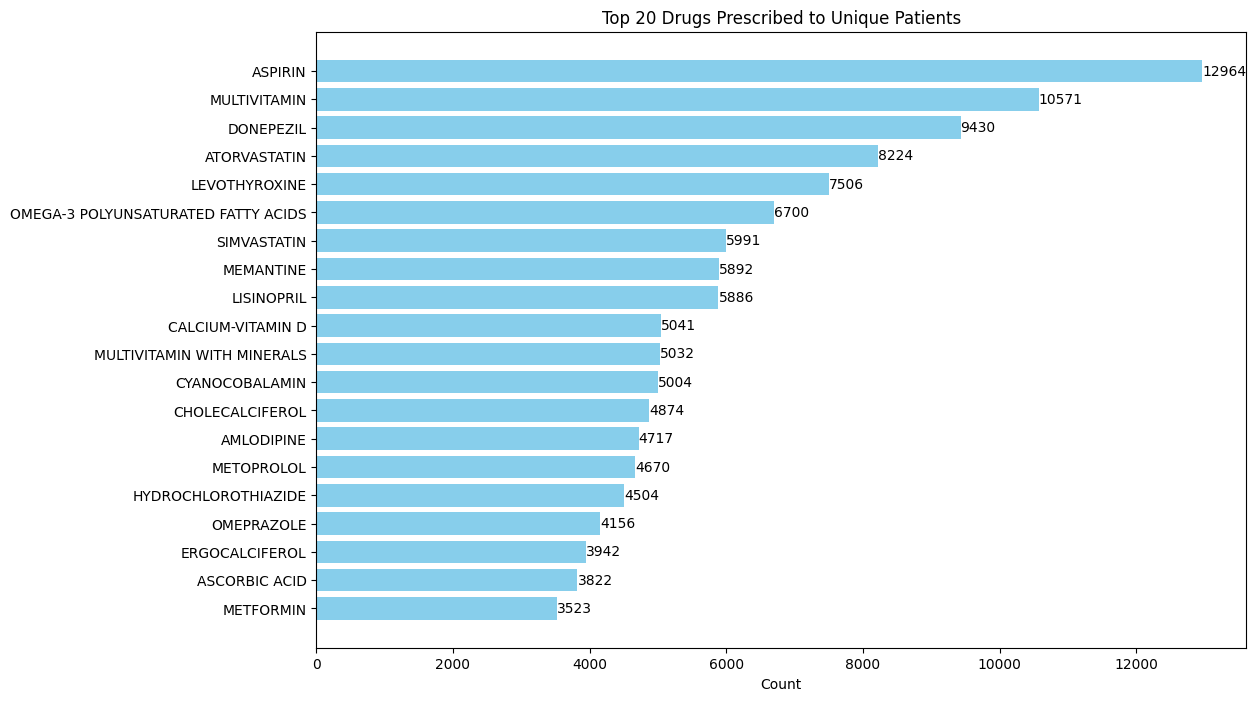

In [13]:
# Filter unique NACCID rows
drug_cols = [f'DRUG{i}' for i in range(1, 41)]
df[drug_cols] = df[drug_cols].fillna('No Drug')
unique_patient_drugs = df.drop_duplicates(subset='NACCID')[drug_cols]

# Count drugs prescribed to unique patients
drug_counts_unique = Counter()
for _, row in unique_patient_drugs.iterrows():
    unique_drugs = {drug for drug in row if drug != 'No Drug'}
    drug_counts_unique.update(unique_drugs)

# Get the 20 most frequently prescribed drugs
top_20_drugs_unique = drug_counts_unique.most_common(20)

# Plot the results
plt.figure(figsize=(12, 8))
drugs, counts = zip(*top_20_drugs_unique)  # Unzip into separate lists
plt.barh(drugs, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Drugs Prescribed to Unique Patients')
for index, value in enumerate(counts):
    plt.text(value, index, str(value), va='center')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

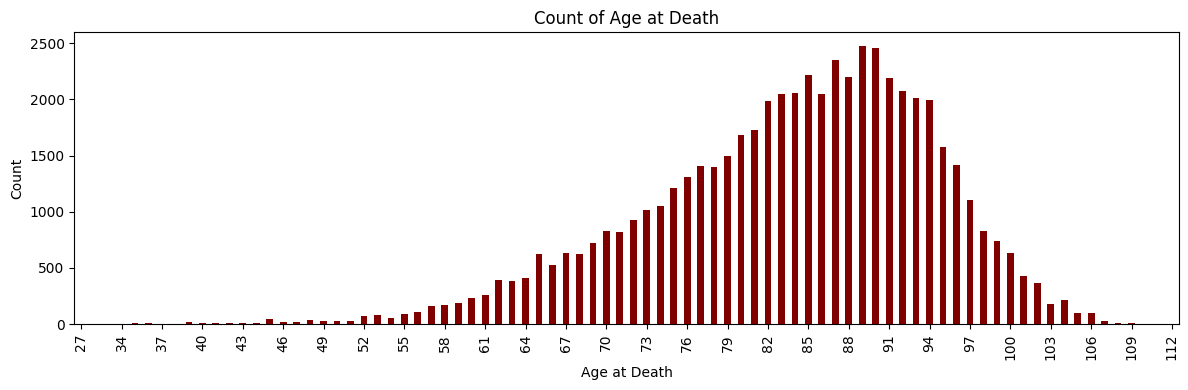

In [14]:
# Count of Age at Death
df_deceased = df[df['NACCDIED'] == 1]
df_deceased['Age_At_Death'] = df_deceased['NACCYOD'] - df_deceased['BIRTHYR']
age_counts = df_deceased['Age_At_Death'].value_counts()
# Create a bar chart
plt.figure(figsize=(12, 4))
ax = age_counts.sort_index().plot(kind='bar', color='maroon')
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::3])
plt.xlabel('Age at Death')
plt.ylabel('Count')
plt.title('Count of Age at Death')
plt.tight_layout()
plt.show()

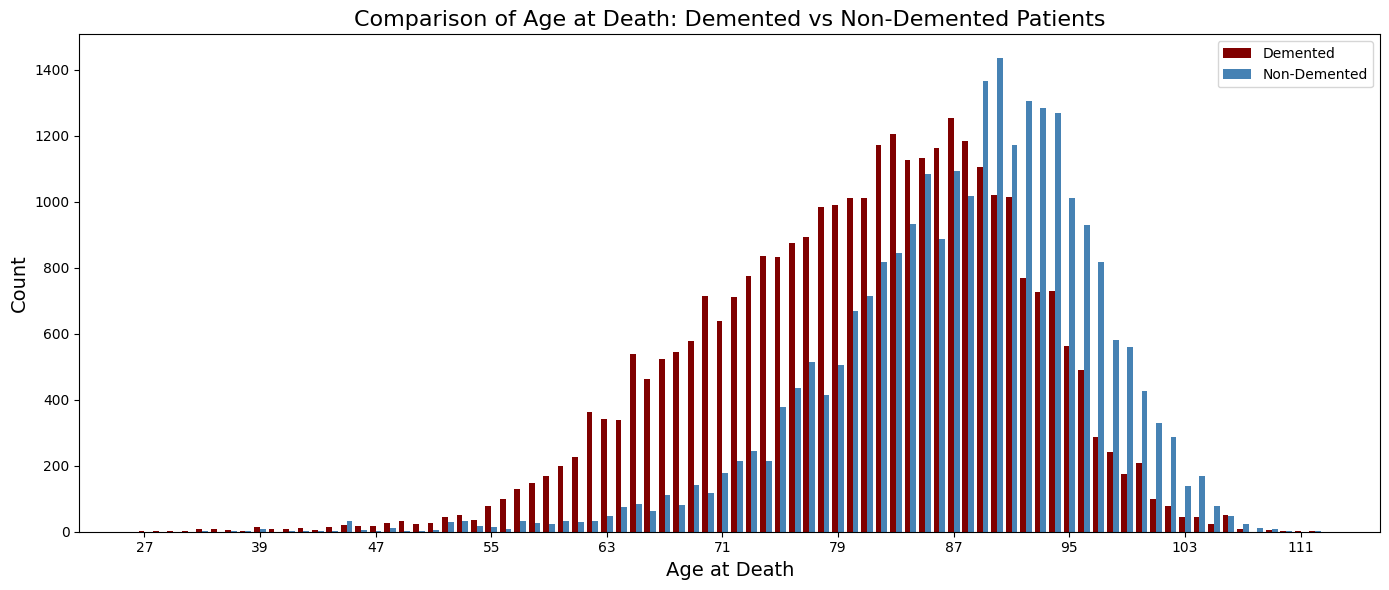

In [15]:
# Comparison of Age at Death: Demented vs Non-Demented Patients'
# Filter for deceased patients
df_deceased = df[df['NACCDIED'] == 1]
df_deceased['Age_At_Death'] = df_deceased['NACCYOD'] - df_deceased['BIRTHYR']

# Split into demented and non-demented groups
demented_deceased = df_deceased[df_deceased['DEMENTED'] == 1]
non_demented_deceased = df_deceased[df_deceased['DEMENTED'] == 0]
demented_age_counts = demented_deceased['Age_At_Death'].value_counts()
non_demented_age_counts = non_demented_deceased['Age_At_Death'].value_counts()

all_ages = sorted(set(demented_age_counts.index).union(set(non_demented_age_counts.index)))
demented_counts = [demented_age_counts.get(age, 0) for age in all_ages]
non_demented_counts = [non_demented_age_counts.get(age, 0) for age in all_ages]

# Plot the grouped bar chart
plt.figure(figsize=(14, 6))
bar_width = 0.4
x = range(len(all_ages))

plt.bar(x, demented_counts, width=bar_width, color='maroon', label='Demented')
plt.bar([pos + bar_width for pos in x], non_demented_counts, width=bar_width, color='steelblue', label='Non-Demented')
plt.xlabel('Age at Death', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Comparison of Age at Death: Demented vs Non-Demented Patients', fontsize=16)
step = max(1, len(all_ages) // 10)
plt.xticks(
    [pos + bar_width / 2 for pos in x][::step],
    all_ages[::step],
    fontsize=10
)
plt.legend()
plt.tight_layout()
plt.show()

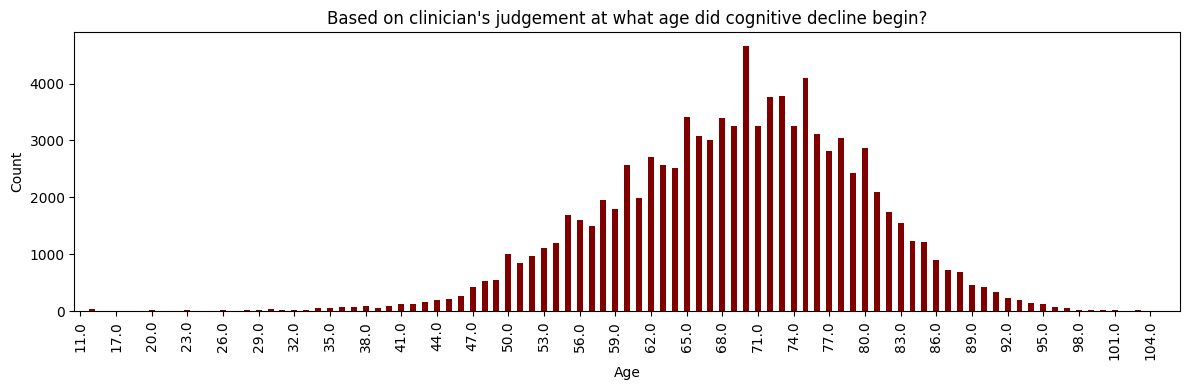

In [16]:
# Based on clinician's judgement at what age did cognitive decline begin?
df_decage = df[~df['DECAGE'].isin([999, 888])]
decage_counts = df_decage['DECAGE'].value_counts()
# Create a bar chart
plt.figure(figsize=(12, 4))
ax = decage_counts.sort_index().plot(kind='bar', color='maroon')
ax.set_xticks(ax.get_xticks()[::3])  # Display every 3rd tick
plt.xlabel("Age")
plt.ylabel('Count')
plt.title("Based on clinician's judgement at what age did cognitive decline begin?")
plt.tight_layout()

# Show the plot
plt.show()

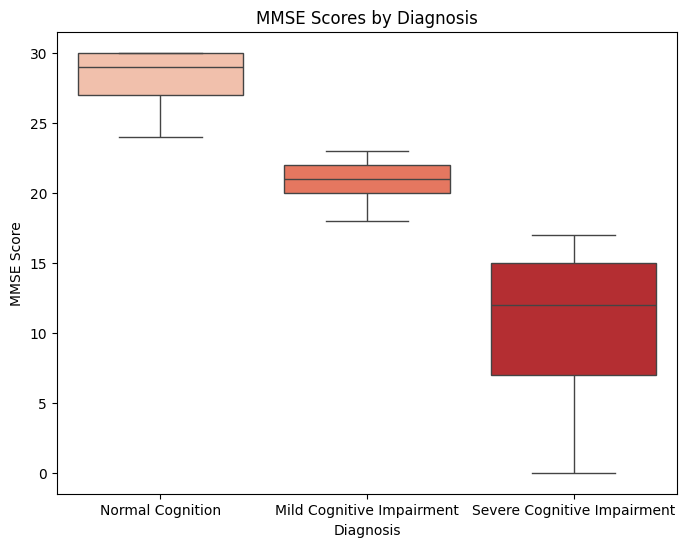

In [17]:
# MMSE Scores by Diagnosis
# Function to assign diagnosis based on MMSE score
def assign_diagnosis(score):
    if 24 <= score <= 30:
        return 'Normal Cognition'
    elif 18 <= score <= 23:
        return 'Mild Cognitive Impairment'
    elif 0 <= score <= 17:
        return 'Severe Cognitive Impairment'
    elif score in [88, 95, 96, 97, 98, -4]:
        return 'Data Unavailable'
    else:
        return 'Unknown'

# Apply the function to create the Diagnosis column
df['Diagnosis'] = df['NACCMMSE'].apply(assign_diagnosis)
# Clean the MMSE column by removing invalid or unavailable scores
valid_scores = range(0, 31)
df['NACCMMSE_cleaned'] = df['NACCMMSE'].apply(lambda x: x if x in valid_scores else None)
filtered_df = df[df['Diagnosis'] != 'Data Unavailable']

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_df, x='Diagnosis', y='NACCMMSE_cleaned', palette='Reds')
plt.title('MMSE Scores by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE Score')
plt.show()

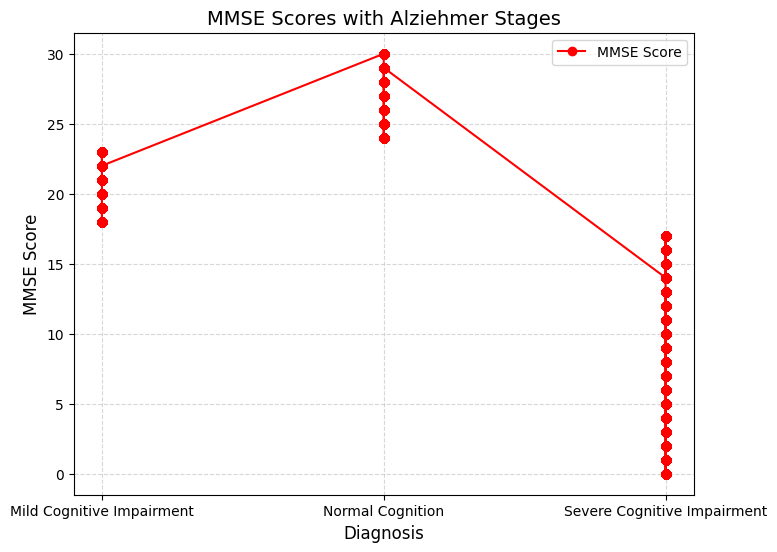

In [18]:
# MMSE Scores with Alziehmer Stages
# Sorting the data by Diagnosis
df_sorted = df.sort_values(by='Diagnosis')

# Creating the line chart for all MMSE scores
plt.figure(figsize=(8, 6))
plt.plot(df_sorted['Diagnosis'], df_sorted['NACCMMSE_cleaned'], marker='o', linestyle='-', color='red', label='MMSE Score')
plt.title('MMSE Scores with Alziehmer Stages', fontsize=14)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('MMSE Score', fontsize=12)
#plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

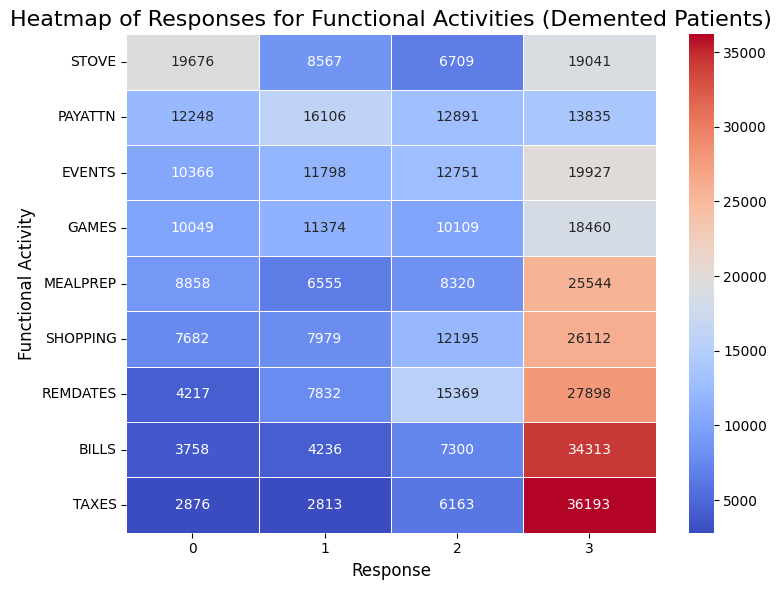

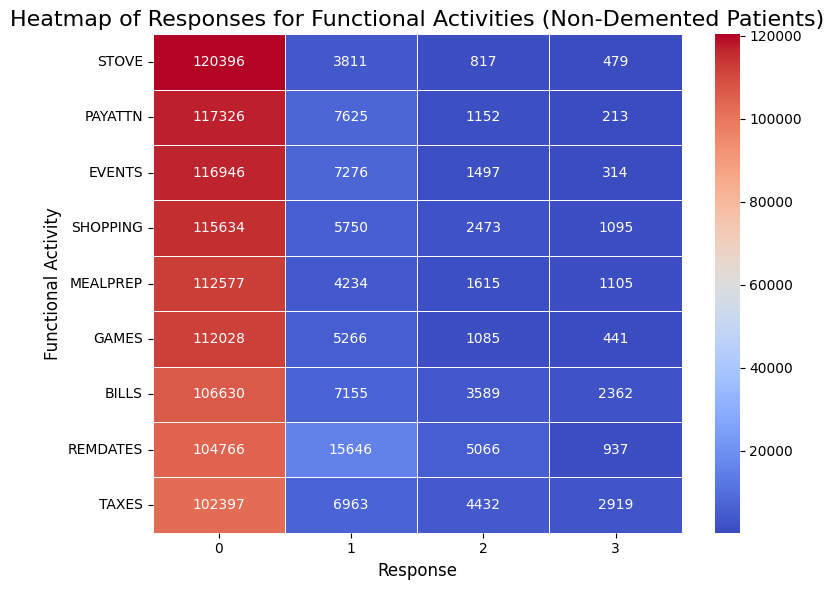

In [19]:
# Heatmap of Responses for Functional Activities
functional_columns = ['BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS', 'PAYATTN', 'REMDATES']
# Clean the data by replacing non-numeric codes with NaN (e.g., -4, 8, 9)
df[functional_columns] = df[functional_columns].replace({-4: None, 8: None, 9: None})

# Filter the data for demented and non-demented patients
df_demented = df[df['DEMENTED'] == 1]
df_non_demented = df[df['DEMENTED'] == 0]
df_melted_demented = pd.melt(df_demented, id_vars=['DEMENTED'], value_vars=functional_columns,
                             var_name='Functional Activity', value_name='Response')
df_melted_non_demented = pd.melt(df_non_demented, id_vars=['DEMENTED'], value_vars=functional_columns,
                                 var_name='Functional Activity', value_name='Response')

# Calculate the count of each response per functional activity (Demented)
response_counts_demented = df_melted_demented.groupby(['Functional Activity', 'Response']).size().unstack(fill_value=0)
response_counts_demented = response_counts_demented.sort_values(by=list(response_counts_demented.columns), ascending=False)

# Plot the heatmap for demented patients
plt.figure(figsize=(8,6))
sns.heatmap(response_counts_demented, annot=True, fmt="d", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title('Heatmap of Responses for Functional Activities (Demented Patients)', fontsize=16)
plt.xlabel('Response', fontsize=12)
plt.ylabel('Functional Activity', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate the count of each response per functional activity (Non-Demented)
response_counts_non_demented = df_melted_non_demented.groupby(['Functional Activity', 'Response']).size().unstack(fill_value=0)
response_counts_non_demented = response_counts_non_demented.sort_values(by=list(response_counts_non_demented.columns), ascending=False)

# Plot the heatmap for non-demented patients
plt.figure(figsize=(8,6))
sns.heatmap(response_counts_non_demented, annot=True, fmt="d", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title('Heatmap of Responses for Functional Activities (Non-Demented Patients)', fontsize=16)
plt.xlabel('Response', fontsize=12)
plt.ylabel('Functional Activity', fontsize=12)
plt.tight_layout()
plt.show()

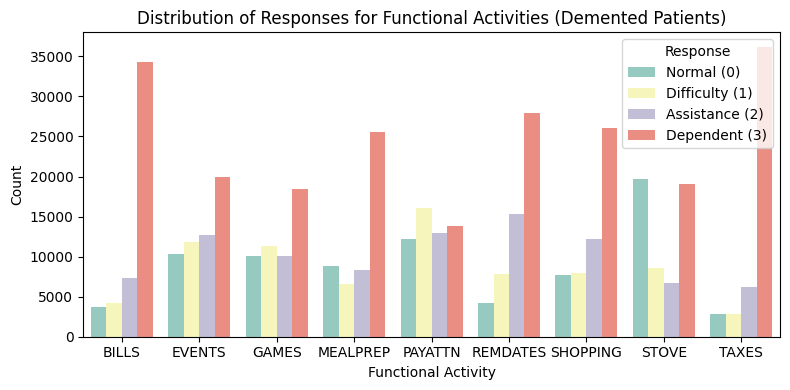

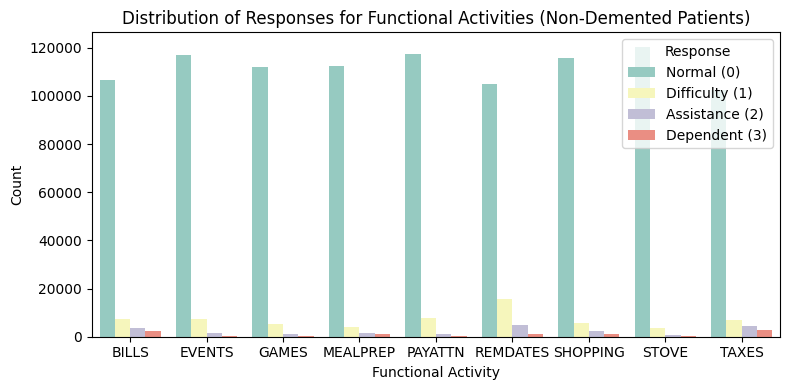

In [20]:
# Distribution of Responses for Functional Activities (Demented Patients)
df_melted_demented['Response'] = pd.Categorical(df_melted_demented['Response'])
df_melted_demented['Functional Activity'] = pd.Categorical(df_melted_demented['Functional Activity'])
# Bar plot to visualize the distribution of responses (0, 1, 2, 3, etc.) for demented patients
plt.figure(figsize=(8,4))
sns.countplot(x='Functional Activity', hue='Response', data=df_melted_demented, palette='Set3')
plt.title('Distribution of Responses for Functional Activities (Demented Patients)')
plt.xlabel('Functional Activity')
plt.ylabel('Count')
#plt.xticks(rotation=45, ha='right')
plt.legend(title='Response', labels=['Normal (0)', 'Difficulty (1)', 'Assistance (2)', 'Dependent (3)'])
plt.tight_layout()
plt.show()

print("\n")

# Distribution of Responses for Functional Activities (Non-Demented Patients)
df_melted_non_demented['Response'] = pd.Categorical(df_melted_non_demented['Response'])
df_melted_non_demented['Functional Activity'] = pd.Categorical(df_melted_non_demented['Functional Activity'])
# Bar plot to visualize the distribution of responses (0, 1, 2, 3, etc.) for non-demented patients
plt.figure(figsize=(8,4))
sns.countplot(x='Functional Activity', hue='Response', data=df_melted_non_demented, palette='Set3')
plt.title('Distribution of Responses for Functional Activities (Non-Demented Patients)')
plt.xlabel('Functional Activity')
plt.ylabel('Count')
#plt.xticks(rotation=45, ha='right')
plt.legend(title='Response', labels=['Normal (0)', 'Difficulty (1)', 'Assistance (2)', 'Dependent (3)'])
plt.tight_layout()
plt.show()

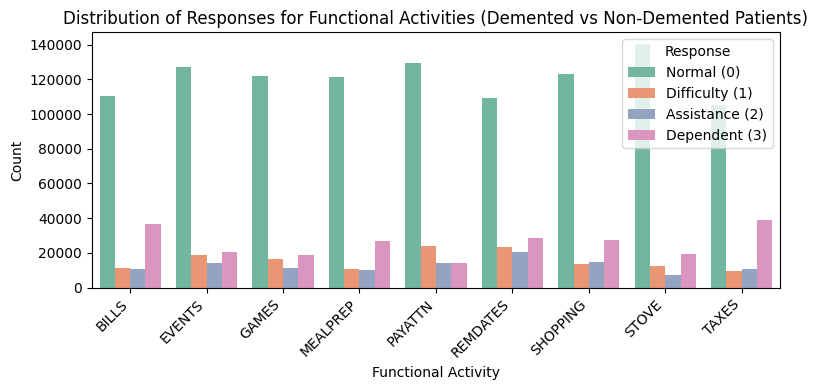

In [21]:
# Distribution of Responses for Functional Activities (Demented vs Non-Demented Patients)

df_melted_all = pd.melt(df, id_vars=['DEMENTED'], value_vars=functional_columns,
                        var_name='Functional Activity', value_name='Response')
df_melted_all['Response'] = pd.Categorical(df_melted_all['Response'])
df_melted_all['Functional Activity'] = pd.Categorical(df_melted_all['Functional Activity'])

plt.figure(figsize=(8,4))
sns.countplot(x='Functional Activity', hue='Response', data=df_melted_all, palette='Set2')
plt.title('Distribution of Responses for Functional Activities (Demented vs Non-Demented Patients)')
plt.xlabel('Functional Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Response', labels=['Normal (0)', 'Difficulty (1)', 'Assistance (2)', 'Dependent (3)'])
plt.tight_layout()
plt.show()

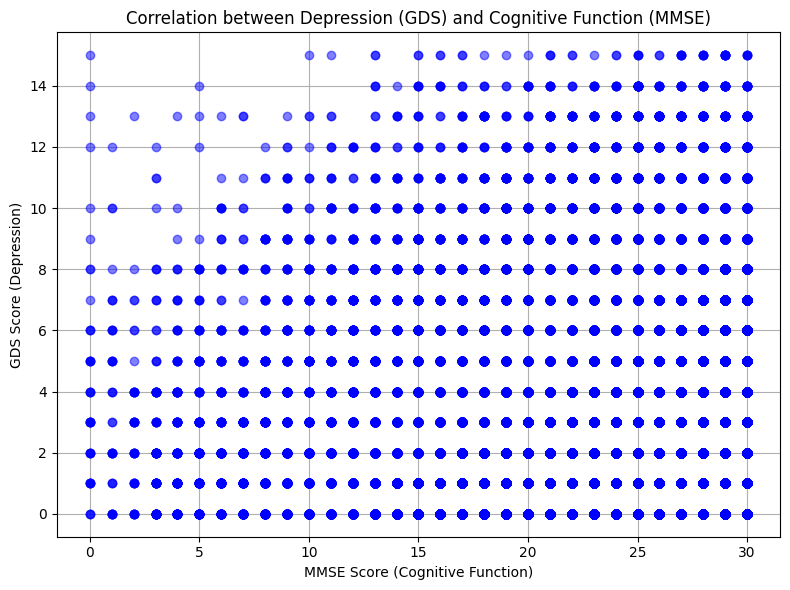

In [22]:
# Correlation between Depression (GDS) and Cognitive Function (MMSE)
# Filtering out invalid values for both NACCGDS and NACCMMSE
df_filtered = df[(df['NACCGDS'] != 88) & (df['NACCGDS'] != -4)]  # Valid GDS values
df_filtered = df_filtered[(df_filtered['NACCMMSE'] != 88) &
                           (df_filtered['NACCMMSE'] != 95) &
                           (df_filtered['NACCMMSE'] != 96) &
                           (df_filtered['NACCMMSE'] != 97) &
                           (df_filtered['NACCMMSE'] != 98) &
                           (df_filtered['NACCMMSE'] != -4)]  # Valid MMSE values

# Plotting the line chart for GDS vs MMSE
plt.figure(figsize=(8, 6))
plt.plot(df_filtered['NACCMMSE'], df_filtered['NACCGDS'], 'o', color='blue', alpha=0.5)
plt.xlabel('MMSE Score (Cognitive Function)')
plt.ylabel('GDS Score (Depression)')
plt.title('Correlation between Depression (GDS) and Cognitive Function (MMSE)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
#Print the column names as a list for exploration
column_names_list = df.columns.tolist()
print("Columns names from NACC dataset:")
print(column_names_list)
df = df.drop(['Diagnosis', 'NACCMMSE_cleaned'], axis=1)
print("\nSize of explored dataset: ", df.shape)

Columns names from NACC dataset:
['NACCID', 'NACCADC', 'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS', 'NACCCORE', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'INHISPOX', 'NACCNINR', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX', 'INKNOWN', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCAM', 'NACCAMX', 'NACCAMS', 'NACCAMSX', 'NACCFM', 'NACCFMX', 'NACCFMS', 'NACCFMSX', 'NACCOM', 'NACCOMX', 'NACCOMS', 'NACCOMSX', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG1', 'DRUG2', 'DRUG3', 'DRUG4', 'DRUG5', 'DRUG6', 'DRUG7', 'DRUG8', 'DRUG9', 'DRUG10', 'DRUG11', 'DRUG12', 'DRUG13', 'DRUG14', 'DRUG

### Data Cleaning & Preprocessing

In [24]:
# Sample a fraction of the dataset
df1 = df.sample(frac=0.2, random_state=42)
print("Size of Considered Dataset: ", df1.shape)

Size of Considered Dataset:  (38083, 1024)


In [25]:
# Get the list of columns with more than 10% missing values
missing_cols = df1.columns[df1.isnull().mean() > 0.10]

# Print the list of columns
print("No of columns with more than 10% missing values:", missing_cols.shape)
print("\n Columns with more than 10% missing values:")
print(missing_cols.tolist())

No of columns with more than 10% missing values: (129,)

 Columns with more than 10% missing values:
['HISPORX', 'RACEX', 'RACESECX', 'RACETERX', 'PRIMLANX', 'INHISPOX', 'INRACEX', 'INRASECX', 'INRATERX', 'INRELTOX', 'NACCAMX', 'NACCAMSX', 'NACCFMX', 'NACCFMSX', 'NACCOMX', 'NACCOMSX', 'CVOTHRX', 'NCOTHRX', 'ARTHTYPX', 'OTHSLEEX', 'ABUSX', 'PSYCDISX', 'CVDIMAGX', 'SPEECHX', 'FACEXPX', 'TRESTFAX', 'TRESTRHX', 'TRESTLHX', 'TRESTRFX', 'TRESTLFX', 'TRACTRHX', 'TRACTLHX', 'RIGDNEX', 'RIGDUPRX', 'RIGDUPLX', 'RIGDLORX', 'RIGDLOLX', 'TAPSRTX', 'TAPSLFX', 'HANDMVRX', 'HANDMVLX', 'HANDATRX', 'HANDATLX', 'LEGRTX', 'LEGLFX', 'ARISINGX', 'POSTUREX', 'GAITX', 'POSSTABX', 'BRADYKIX', 'NPIQINFX', 'BILLS', 'TAXES', 'GAMES', 'MEALPREP', 'OTHNEURX', 'COGOTHRX', 'NACCCGFX', 'COGMODEX', 'BEOTHRX', 'NACCBEFX', 'BEMODEX', 'MOMODEX', 'MMSELANX', 'NPSYLANX', 'MOCALANX', 'OTHBIOMX', 'OTHMUTX', 'FTLDSUBX', 'OTHCOGX', 'OTHPSYX', 'COGOTHX', 'COGOTH2X', 'COGOTH3X', 'CANCSITE', 'ARTYPEX', 'SLEEPOTX', 'ANTIENCX', 'OTH

In [26]:
# Drop unwanted columns
col_to_drop = ['HISPORX', 'RACEX', 'RACESECX', 'RACETERX', 'PRIMLANX', 'INHISPOX', 'INRACEX', 'INRASECX', 'INRATERX',
               'INRELTOX', 'NACCAMX', 'NACCAMSX', 'NACCFMX', 'NACCFMSX', 'NACCOMX', 'NACCOMSX', 'CVOTHRX', 'NCOTHRX',
               'ARTHTYPX', 'OTHSLEEX', 'ABUSX', 'PSYCDISX', 'CVDIMAGX', 'SPEECHX', 'FACEXPX', 'TRESTFAX', 'TRESTRHX',
               'TRESTLHX', 'TRESTRFX', 'TRESTLFX', 'TRACTRHX', 'TRACTLHX', 'RIGDNEX', 'RIGDUPRX', 'RIGDUPLX', 'RIGDLORX',
               'RIGDLOLX', 'TAPSRTX', 'TAPSLFX', 'HANDMVRX', 'HANDMVLX', 'HANDATRX', 'HANDATLX', 'LEGRTX', 'LEGLFX',
               'ARISINGX', 'POSTUREX', 'GAITX', 'POSSTABX', 'BRADYKIX', 'NPIQINFX', 'OTHNEURX', 'COGOTHRX', 'NACCCGFX',
               'COGMODEX', 'BEOTHRX', 'NACCBEFX', 'BEMODEX', 'MOMODEX', 'MMSELANX', 'NPSYLANX', 'MOCALANX', 'RESPOTHX',
               'OTHBIOMX', 'OTHMUTX', 'FTLDSUBX', 'OTHCOGX', 'OTHPSYX', 'COGOTHX', 'COGOTH2X', 'COGOTH3X', 'ARTYPEX',
               'SLEEPOTX', 'ANTIENCX', 'OTHCONDX', 'NPFIXX', 'NPTANX', 'NPABANX', 'NPASANX', 'NPTDPANX', 'NPHISOX',
               'NPPATHOX', 'NACCWRI1', 'NACCWRI2', 'NACCWRI3', 'NPFAUT1', 'NPFAUT2', 'NPFAUT3','NPFAUT4', 'NPFHSPEC',
               'NPOTH1X', 'NPOTH2X', 'NPOTH3X','CANCSITE', 'NGDSWEAC'
               ]
valid_col_to_drop = [col for col in col_to_drop if col in df1.columns]
df1.drop(columns=col_to_drop, inplace=True)

gene_col =     ['ADGCGWAS', 'ADGCEXOM', 'ADGCRND', 'ADGCEXR', 'NGDSGWAS', 'NGDSEXOM', 'NGDSWGS', 'NGDSWES',
                 'NGDSGWAC', 'NGDSEXAC', 'NGDSWGAC', 'NACCNCRD', 'NACCAPOE', 'NACCNE4S'
                ]
valid_gene_col = [col for col in gene_col if col in df1.columns]
df1.drop(columns=gene_col, inplace=True)

data_misg = ['NPNIT', 'NPCERAD', 'NPADRDA', 'NPOCRIT', 'NPVOTH', 'NPLEWYCS',
              'NPGENE', 'NPTAUHAP', 'NPPRNP', 'NPCHROM', 'NPPNORM', 'NPCNORM',
              'NPPADP', 'NPCADP', 'NPPAD', 'NPCAD', 'NPPLEWY', 'NPCLEWY', 'NPPVASC',
              'NPCVASC', 'NPPFTLD', 'NPCFTLD', 'NPPHIPP', 'NPCHIPP', 'NPPPRION',
              'NPCPRION', 'NPPOTH1', 'NPCOTH1', 'NPPOTH2', 'NPCOTH2', 'NPPOTH3',
              'NPCOTH3'
            ]
valid_data_misg = [col for col in data_misg if col in df1.columns]
df1.drop(columns=data_misg, inplace=True)

missing_cols = df1.columns[df1.isnull().mean() > 0.10]
print("No of columns with more than 10% missing values (after cleaning):", missing_cols.shape)

No of columns with more than 10% missing values (after cleaning): (4,)


In [27]:
# Handling multiple columns of drugs prescribed to patients.
drug_cols = [f'DRUG{i}' for i in range(1, 41)]
df1[drug_cols] = df1[drug_cols].fillna('No Drug')
# Clean and standardise drug names
def clean_drug_name(drug):
    return 'No Drug' if pd.isna(drug) or drug == 'No Drug' else drug.lower().replace('-','').strip()
df1[drug_cols] = df1[drug_cols].applymap(clean_drug_name)

# Create a column for unique drugs per patient
df1['unique_drugs_per_patient'] = df1[drug_cols].apply(
    lambda row: ','.join(sorted({drug for drug in row if drug != 'No Drug'})), axis = 1
)

drug_counts = Counter(
    drug for drugs in df1['unique_drugs_per_patient'] if drugs
    for drug in drugs.split(',')
)

print(f"No of unique drugs in the dataset: {len(drug_counts)}")
# Display top 10 most frequent drugs
print("\n The 10 most frequently prescribed drug: \n",drug_counts.most_common(10))

df1['drug_count'] = df1['unique_drugs_per_patient'].apply(lambda x: len(set(x.split(','))))
df2 = df1.copy()
df2 = df2.drop(columns=['unique_drugs_per_patient'])
# Drop the original drug columns
df2 = df2.drop(columns=[f'DRUG{i}' for i in range(1, 41)])

print("\n Size of df1: ", df1.shape)
print("\n Size of df2: ", df2.shape)

No of unique drugs in the dataset: 1847

 The 10 most frequently prescribed drug: 
 [('aspirin', 12398), ('multivitamin', 9990), ('omega3 polyunsaturated fatty acids', 6568), ('levothyroxine', 6515), ('donepezil', 6398), ('atorvastatin', 6377), ('calciumvitamin d', 5828), ('multivitamin with minerals', 5651), ('simvastatin', 4990), ('memantine', 4733)]

 Size of df1:  (38083, 885)

 Size of df2:  (38083, 844)


In [28]:
categorical_cols = df2.select_dtypes(include=['object', 'category']).columns.tolist()
# Display the list of categorical columns
print("\n Categorical Variables in the Dataset:")
print(categorical_cols)


 Categorical Variables in the Dataset:
['NACCID', 'PACKET', 'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS', 'PAYATTN', 'REMDATES']


In [29]:
# Fit and transform the 'PACKET' column
label_encoder = LabelEncoder()
df2['PACKET_encoded'] = label_encoder.fit_transform(df2['PACKET'])
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Print the mapping
for original, encoded in mapping.items():
    print(f"Original: {original}, Encoded: {encoded}")
df3 = df2.drop(columns=['NACCID', 'PACKET'])

Original: F, Encoded: 0
Original: I, Encoded: 1
Original: IT, Encoded: 2
Original: T, Encoded: 3


In [30]:
# Get percentage of missing values per remaining column
print("Size of df3: ",df3.shape)
missing_percent = df3.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print("\n Missing percent of data in remaining columns of df3: \n",missing_percent)

df3.dropna(inplace=True)
missing_data = df3.isnull().sum()
missing_data = missing_data[missing_data > 0]
print("\n Missing percent of data in remaining columns of df3: \n",missing_data)
print("Size of df3: ",df3.shape)

Size of df3:  (38083, 843)

 Missing percent of data in remaining columns of df3: 
 TAXES       13.418061
GAMES       11.396161
MEALPREP    11.207100
BILLS       10.986529
SHOPPING     5.942284
STOVE        5.635060
EVENTS       4.881443
PAYATTN      4.618859
REMDATES     4.445553
NPPATHO      0.438516
BPSYS        0.267836
HRATE        0.267836
BPDIAS       0.267836
WEIGHT       0.267836
HEIGHT       0.267836
PARKSIGN     0.010503
RESTTRL      0.010503
RESTTRR      0.010503
NORMEXAM     0.010503
SLOWINGR     0.010503
RIGIDL       0.010503
RIGIDR       0.010503
BRADY        0.010503
PARKGAIT     0.010503
POSTINST     0.010503
CVDSIGNS     0.010503
SLOWINGL     0.010503
CORTDEF      0.010503
SIVDFIND     0.010503
CVDMOTR      0.010503
CVDMOTL      0.010503
CORTVISR     0.010503
SOMATL       0.010503
SOMATR       0.010503
CORTVISL     0.010503
PSPCBS       0.010503
EYEPSP       0.010503
DYSPSP       0.010503
AXIALPSP     0.010503
GAITPSP      0.010503
APRAXSP      0.010503
APRAXL       0

In [31]:
df3 = df3.drop('NACCADC', axis=1)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_columns', 30)
df3.dtypes.value_counts()

column_names_list = df3.columns.tolist()
print("Columns names from NACC dataset:")
print(column_names_list)
print("\nSize of df3: ",df3.shape)

Columns names from NACC dataset:
['FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS', 'NACCCORE', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'NACCNINR', 'INRACE', 'INRASEC', 'INRATER', 'INEDUC', 'INRELTO', 'INKNOWN', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCAM', 'NACCAMS', 'NACCFM', 'NACCFMS', 'NACCOM', 'NACCOMS', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ', 'CVHATT', 'HATTMULT', 'HATTYEAR', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACDEF', 'CVPACE', 'CVCHF', 'CVANGINA', 'CVHVALVE', 'CVOTHR', 'CBSTROKE', 'STROKMUL', 'NACCSTYR', 'CBTIA', 'TIAMULT', 'NACCTIYR', 'PD', 'PDYR', 'PDOTHR', 'PDOTHRYR', 'SEIZURES', 'NACCTBI', 'TBI', 'TBI

### Feature Engineering

In [32]:
# Assign target vaiable ('DEMENTED') to 'y' and rest to input variables 'X'
X = df3.drop(columns=['DEMENTED'])
y = df3['DEMENTED']
X.info()
y.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 28232 entries, 42330 to 64867
Columns: 841 entries, FORMVER to PACKET_encoded
dtypes: float64(103), int64(729), object(9)
memory usage: 181.4+ MB


DEMENTED
0    20622
1     7610
Name: count, dtype: int64

In [33]:
# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
y.value_counts()

object_cols = X.select_dtypes(include=['float64','int32','int64']).columns
X[object_cols] = X[object_cols].astype('category')
X.dtypes

FORMVER           category
VISITMO           category
VISITDAY          category
VISITYR           category
NACCVNUM          category
                    ...   
NPATGFR2          category
NPATGFR3          category
NPATGFR4          category
drug_count        category
PACKET_encoded    category
Length: 841, dtype: object

In [34]:
# Split the dataset into training and test sets
stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Y_train: ", y_train)
print("Y_test: ", y_test)

Y_train:  16067    0
25055    0
28973    1
20286    1
1921     0
        ..
6265     0
11284    1
38158    1
860      1
15795    0
Name: DEMENTED, Length: 28870, dtype: int64
Y_test:  30779    1
18783    1
23105    0
3230     1
33512    1
        ..
11177    0
24050    0
38614    1
26923    1
25031    1
Name: DEMENTED, Length: 12374, dtype: int64


In [35]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Function to process data in batches for one-hot encoding
def process_in_batches(X, encoder, batch_size=1000):
    n_batches = len(X) // batch_size + 1  # Calculate the number of batches
    encoded_batches = []
    for i in range(n_batches):
        # Extract batch
        X_batch = X[i * batch_size:(i + 1) * batch_size]
        # One-hot encode the batch
        if i == 0:
            encoded_batch = encoder.fit_transform(X_batch)
        else:
            encoded_batch = encoder.transform(X_batch)
        # Store the encoded batch
        encoded_batches.append(encoded_batch)
    # Concatenate all batches back together
    return pd.DataFrame(np.vstack(encoded_batches), columns=encoder.get_feature_names_out())

In [36]:
# Apply batch processing for one-hot encoding
X_train_encoded = process_in_batches(X_train, encoder)
X_test_encoded = encoder.transform(X_test) # For test data, apply transform directly
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out())
X_train_encoded.head()
print("Size of X_train_encoded: ", X_train_encoded.shape)
print("Size of X_test_encoded: ", X_test_encoded.shape)

Size of X_train_encoded:  (28870, 19912)
Size of X_test_encoded:  (12374, 19912)


### Dimensionality reduction

- PCA with evaluation

In [ ]:
# PCA for Dimensionality Reduction
X_train_encoded = process_in_batches(X_train, encoder, batch_size=1000)
pca = PCA(n_components=0.95, svd_solver='full')  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)
print(f"X_train shape: {X_train.shape}, X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}, X_test_pca shape: {X_test_pca.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

In [ ]:
# Evaluation of PCA Model
# 1 Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', linestyle='-', label='Cumulative Explained Variance')
plt.title('Explained Variance Ratio and Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# 2 Reconstruction Error
X_reconstructed = pca.inverse_transform(X_train_pca)
reconstruction_error = np.mean((X_train_encoded - X_reconstructed)**2)
print("Reconstruction Error:", reconstruction_error)

# 3 Silhouette Score
silhouette_avg_train = silhouette_score(X_train_pca, y_train)
print("Silhouette Score (Train):", silhouette_avg_train)
silhouette_avg_test = silhouette_score(X_test_pca, y_test)
print("Silhouette Score (Test):", silhouette_avg_test)

- t-SNE with evaluation

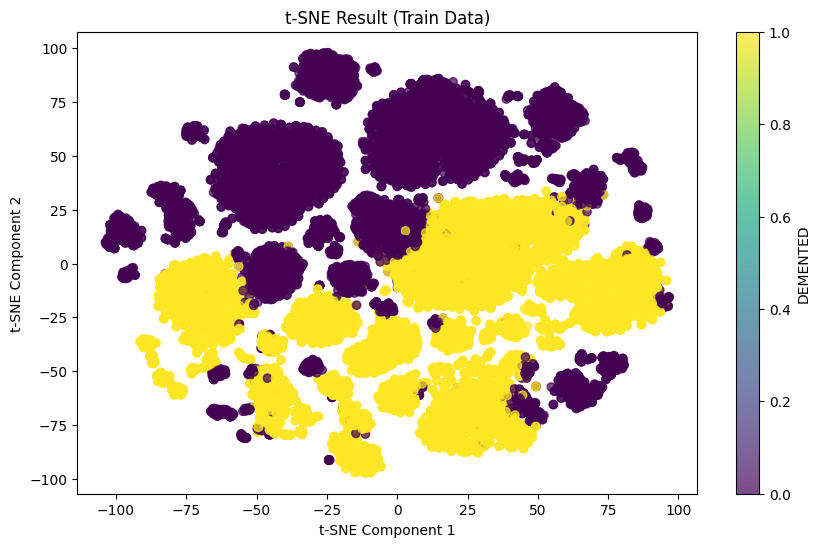

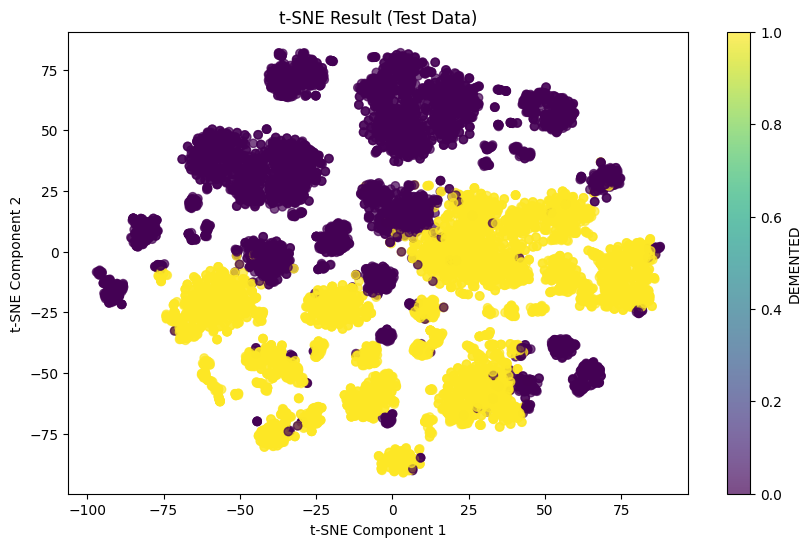

In [40]:
# Apply t-SNE to the training data
tsne = TSNE(n_components=2,  perplexity=20, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_encoded)

# Visualize t-SNE result for train data
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("t-SNE Result (Train Data)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='DEMENTED')
plt.show()

# Apply t-SNE to test data (using the above model)
X_test_tsne = tsne.fit_transform(X_test_encoded)

# Visualize t-SNE result for test data
plt.figure(figsize=(10, 6))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.title("t-SNE Result (Test Data)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='DEMENTED')
plt.show()

- Auto Encoder with evaluation

In [37]:
# PyTorch Autoencoder for Dimensionality Reduction
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()

        )
        self.decoder = nn.Sequential(
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [38]:
# Function to train Autoencoder with optional L1/L2 sparsity regularization
def train_autoencoder(input_dim, latent_dim, l1_lambda=0.001, l2_lambda=0.01, num_epochs=50, batch_size=256):
    autoencoder = Autoencoder(input_dim, latent_dim).to(device) # Move model to device
    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train_encoded.values, dtype=torch.float32).to(device) #Move data to device
    train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for data in train_loader:
            X_batch, _ = data
            optimizer.zero_grad()
            outputs = autoencoder(X_batch)
            # Compute reconstruction loss
            reconstruction_loss = criterion(outputs, X_batch)
            # Add sparsity regularization terms
            l1_reg = l1_lambda * sum(torch.norm(param, 1) for param in autoencoder.parameters())
            l2_reg = l2_lambda * sum(torch.norm(param, 2) for param in autoencoder.parameters())
            loss = reconstruction_loss + l1_reg + l2_reg
            loss.backward()
            optimizer.step()
    return autoencoder

# Evaluate Reconstruction Error
def evaluate_reconstruction_error(autoencoder, data_loader, criterion):
    autoencoder.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for data in data_loader:
            X_batch, _ = data
            reconstructed = autoencoder(X_batch)
            loss = ((reconstructed - X_batch) ** 2).mean(dim=1)
            reconstruction_errors.extend(loss.numpy())
    return np.mean(reconstruction_errors), reconstruction_errors

In [39]:
# Grid Search over latent space sizes
latent_dims = [17]
# After evaluation of latent dims = [8,12,14,15,16,17,18,24,32]
# latent_dim =[17] had the best metrics
results = []

for latent_dim in latent_dims:
    autoencoder = train_autoencoder(
        input_dim=X_train_encoded.shape[1],
        latent_dim=latent_dim,
        l1_lambda=1e-6,  # L1 regularization
        l2_lambda=1e-5,  # L2 regularization
        num_epochs=50,
        batch_size=256
    )

    # Extract encoded features
    X_train_tensor = torch.tensor(X_train_encoded.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_encoded.values, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=256, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_tensor, X_test_tensor), batch_size=256, shuffle=False)
    X_train_autoencoded = autoencoder.encoder(X_train_tensor).detach().numpy()
    X_test_autoencoded = autoencoder.encoder(X_test_tensor).detach().numpy()

    # Evaluate reconstruction errors
    train_reconstruction_error, _ = evaluate_reconstruction_error(autoencoder, train_loader, nn.BCELoss())
    test_reconstruction_error, _ = evaluate_reconstruction_error(autoencoder, test_loader, nn.BCELoss())
    # Evaluate silhouette score
    silhouette_avg_train = silhouette_score(X_train_autoencoded, y_train)
    silhouette_avg_test = silhouette_score(X_test_autoencoded, y_test)

    # Log results
    results.append({
        "latent_dim": latent_dim,
        "train_reconstruction_error": train_reconstruction_error,
        "test_reconstruction_error": test_reconstruction_error,
    })
    print(f"\nTraining Autoencoder with latent dim: {latent_dim} ")
    print(f"Reconstruction Error::")
    print(f"Train: {train_reconstruction_error:.4f},    Test: {test_reconstruction_error:.4f}")
    print(f"Silhouette Score::")
    print(f"Train: {silhouette_avg_train:.4f},    Test: {silhouette_avg_test:.4f}")

print("\n")
print("Size of X_train_autoencoded: ", X_train_autoencoded.shape)
print("Size of X_test_autoencoded: ", X_test_autoencoded.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)


Training Autoencoder with latent dim: 17 
Reconstruction Error::
Train: 0.0068,    Test: 0.0067
Silhouette Score::
Train: 0.1485,    Test: 0.1470


Size of X_train_autoencoded:  (28870, 128)
Size of X_test_autoencoded:  (12374, 128)
Size of y_train:  (28870,)
Size of y_test:  (12374,)


### Binary Classification Models

In [41]:
# Parameters for Binary Classification model
lr_param_grid = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']}
tree_param_grid = {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear'], 'gamma': ['scale', 'auto']}

In [42]:
# Evaluation function for (Scikit-Learn) Binary Classification Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predictions for training data
    y_train_pred = model.predict(X_train)
    # Metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    print(f"TRAINING DATA PERFORMANCE:\n  Accuracy: {train_accuracy:.4f}\n  Precision: {train_precision:.4f}\n  Recall: {train_recall:.4f}\n  F1 Score: {train_f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_train, y_train_pred))

    # Predictions for test data
    y_test_pred = model.predict(X_test)
    # Metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    print(f"\nTEST DATA PERFORMANCE:\n  Accuracy: {test_accuracy:.4f}\n  Precision: {test_precision:.4f}\n  Recall: {test_recall:.4f}\n  F1 Score: {test_f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\n")

    # Plot Accuracy for training and test data to check for Overfitting
    plt.figure(figsize=(4, 4))
    plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
    plt.title('Training vs Testing Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()
    print("\n")

    # Confusion Matrix for test data
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix (Test Data)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve and AUC (for binary classification)
    if hasattr(model, "predict_proba"):  # Ensure the model supports predict_proba
        y_test_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
        roc_auc = auc(fpr, tpr)
        print(f"\nAUC (Test Data): {roc_auc:.4f}")
        # Plot ROC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

- Binary Classification Models with PCA Performance:

WITH PCA::: 
LOGISTIC REGRESSION:

 Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

TRAINING DATA PERFORMANCE:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7177
           1       1.00      1.00      1.00      7223

    accuracy                           1.00     14400
   macro avg       1.00      1.00      1.00     14400
weighted avg       1.00      1.00      1.00     14400


TEST DATA PERFORMANCE:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3109
           1       1.00      1.00      1.00      3063

    accuracy                           1.00      6172
   macro avg       1.00      1.00      1.00      6172
weighted avg       1.00      1.00      1.00      6172



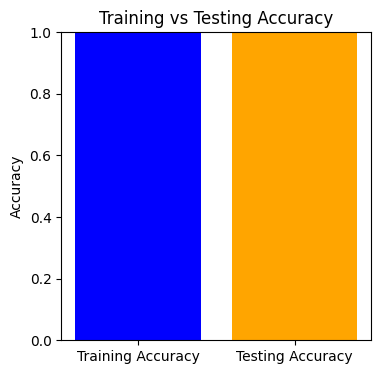

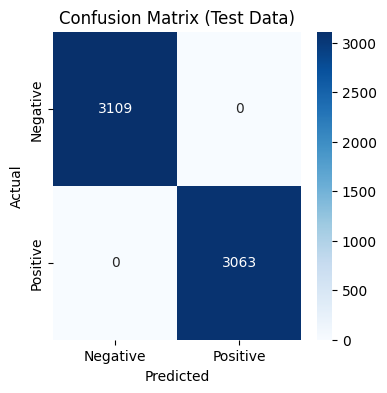


AUC (Test Data): 1.0000


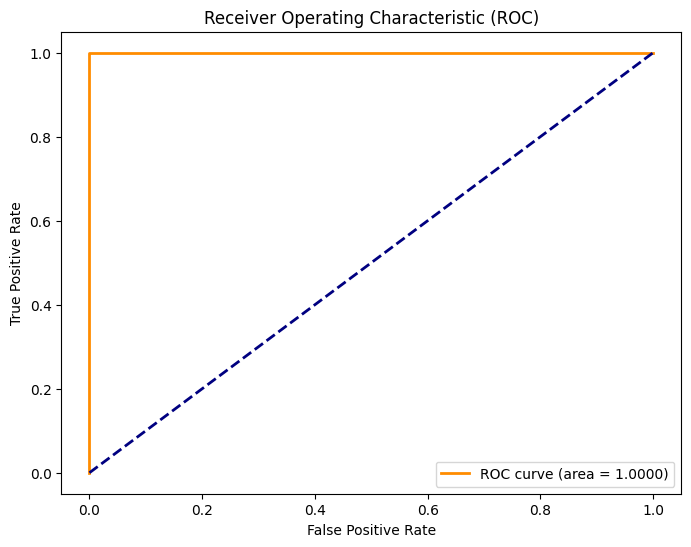

In [ ]:
print("WITH PCA::: ")
print("LOGISTIC REGRESSION:")
lr_grid_search_pca = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring='f1')
lr_grid_search_pca.fit(X_train_pca, y_train)
print(f"\n Best Params: {lr_grid_search_pca.best_params_}\n")
evaluate_model(lr_grid_search_pca.best_estimator_, X_train_pca, X_test_pca, y_train, y_test)

In [ ]:
print("WITH PCA:::")
print("DECISION TREE:")
tree_grid_search_pca = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5, scoring='f1')
tree_grid_search_pca.fit(X_train_pca, y_train)
print(f"\n Best Params: {tree_grid_search_pca.best_params_}\n")
evaluate_model(tree_grid_search_pca.best_estimator_, X_train_pca, X_test_pca, y_train, y_test)

# Fit the best hyperparams from GridSearchCV to the data
best_tree_model = tree_grid_search_pca.best_estimator_
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree_model,
    feature_names=X_train_pca.columns if hasattr(X_train_pca, "columns") else [f"Feature {i}" for i in range(X_train_pca.shape[1])],
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (with PCA) Visualization")
plt.show()

In [ ]:
print("WITH PCA:::")
print("RANDOM FOREST:")
rf_grid_search_pca = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1')
rf_grid_search_pca.fit(X_train_pca, y_train)
print(f"\n Best Params: {rf_grid_search_pca.best_params_}")
evaluate_model(rf_grid_search_pca.best_estimator_, X_train_pca, X_test_pca, y_train, y_test)

print("\n")
# Extract one of the trees from the Random Forest model
best_rf_model = rf_grid_search_pca.best_estimator_
single_tree = best_rf_model.estimators_[0]  # Get the first tree from the forest

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=X_train_pca.columns if hasattr(X_train_pca, "columns") else [f"Feature {i}" for i in range(X_train_pca.shape[1])],
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (from Random Forest with PCA) Visualization")
plt.show()

In [ ]:
print("WITH PCA:::")
print("SVM:")
svm_grid_search_pca = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='f1')
svm_grid_search_pca.fit(X_train_pca, y_train)
print(f"\n Best Params: {svm_grid_search_pca.best_params_}\n")
evaluate_model(svm_grid_search_pca.best_estimator_, X_train_pca, X_test_pca, y_train, y_test)

- Binary Classification Models with t-SNE Performance:

WITH t-SNE::: 
LOGISTIC REGRESSION:

 Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}

TRAINING DATA PERFORMANCE:
  Accuracy: 0.8730
  Precision: 0.8725
  Recall: 0.8736
  F1 Score: 0.8731
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     72044
           1       0.87      0.87      0.87     72003

    accuracy                           0.87    144047
   macro avg       0.87      0.87      0.87    144047
weighted avg       0.87      0.87      0.87    144047


TEST DATA PERFORMANCE:
  Accuracy: 0.8713
  Precision: 0.8638
  Recall: 0.8818
  F1 Score: 0.8727
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     30847
           1       0.86      0.88      0.87     30888

    accuracy                           0.87     61735
   macro avg       0.87      0.87      0.87     61735
weighted avg       0.87      0.87      0.87     61735



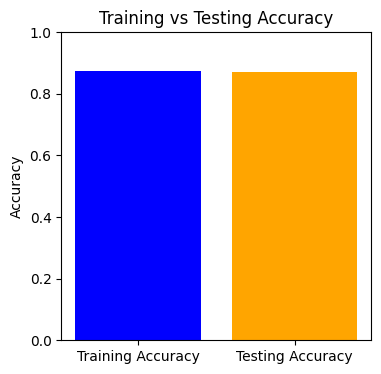

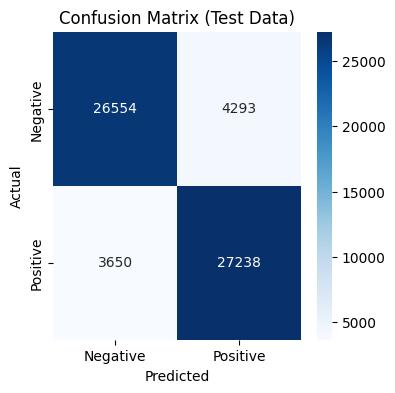


AUC (Test Data): 0.9067


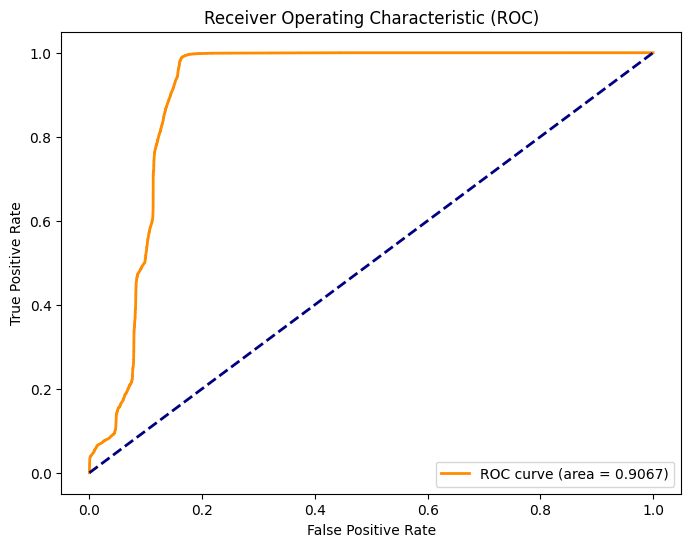

In [ ]:
print("WITH t-SNE::: ")
print("LOGISTIC REGRESSION:")
lr_grid_search_tsne = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring='f1')
lr_grid_search_tsne.fit(X_train_tsne, y_train)
print(f"\n Best Params: {lr_grid_search_tsne.best_params_}\n")
evaluate_model(lr_grid_search_tsne.best_estimator_, X_train_tsne, X_test_tsne, y_train, y_test)

WITH t-SNE:::
DECISION TREE:

 Best Params: {'max_depth': 20, 'min_samples_split': 2}

TRAINING DATA PERFORMANCE:
  Accuracy: 0.9995
  Precision: 0.9990
  Recall: 0.9999
  F1 Score: 0.9995
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72044
           1       1.00      1.00      1.00     72003

    accuracy                           1.00    144047
   macro avg       1.00      1.00      1.00    144047
weighted avg       1.00      1.00      1.00    144047


TEST DATA PERFORMANCE:
  Accuracy: 0.8802
  Precision: 0.8632
  Recall: 0.9038
  F1 Score: 0.8830
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     30847
           1       0.86      0.90      0.88     30888

    accuracy                           0.88     61735
   macro avg       0.88      0.88      0.88     61735
weighted avg       0.88      0.88      0.88     61735





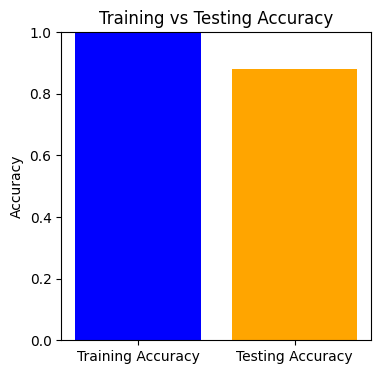

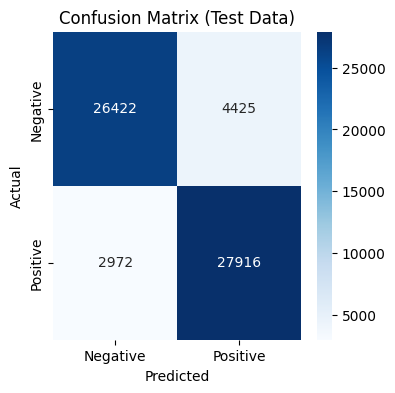


AUC (Test Data): 0.8735


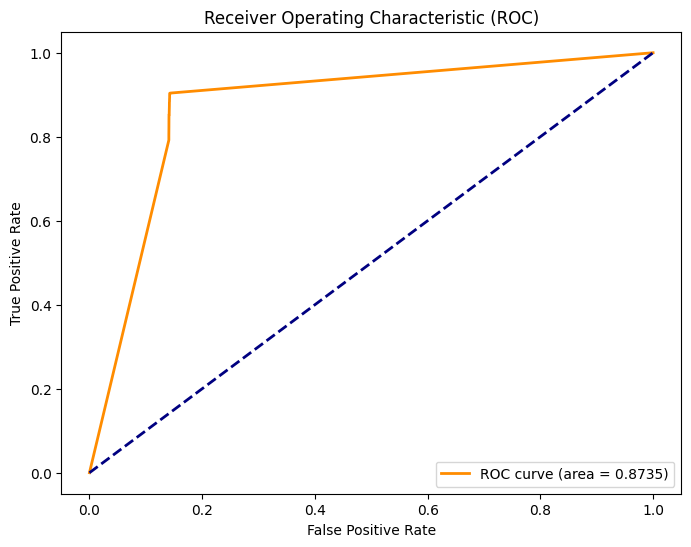

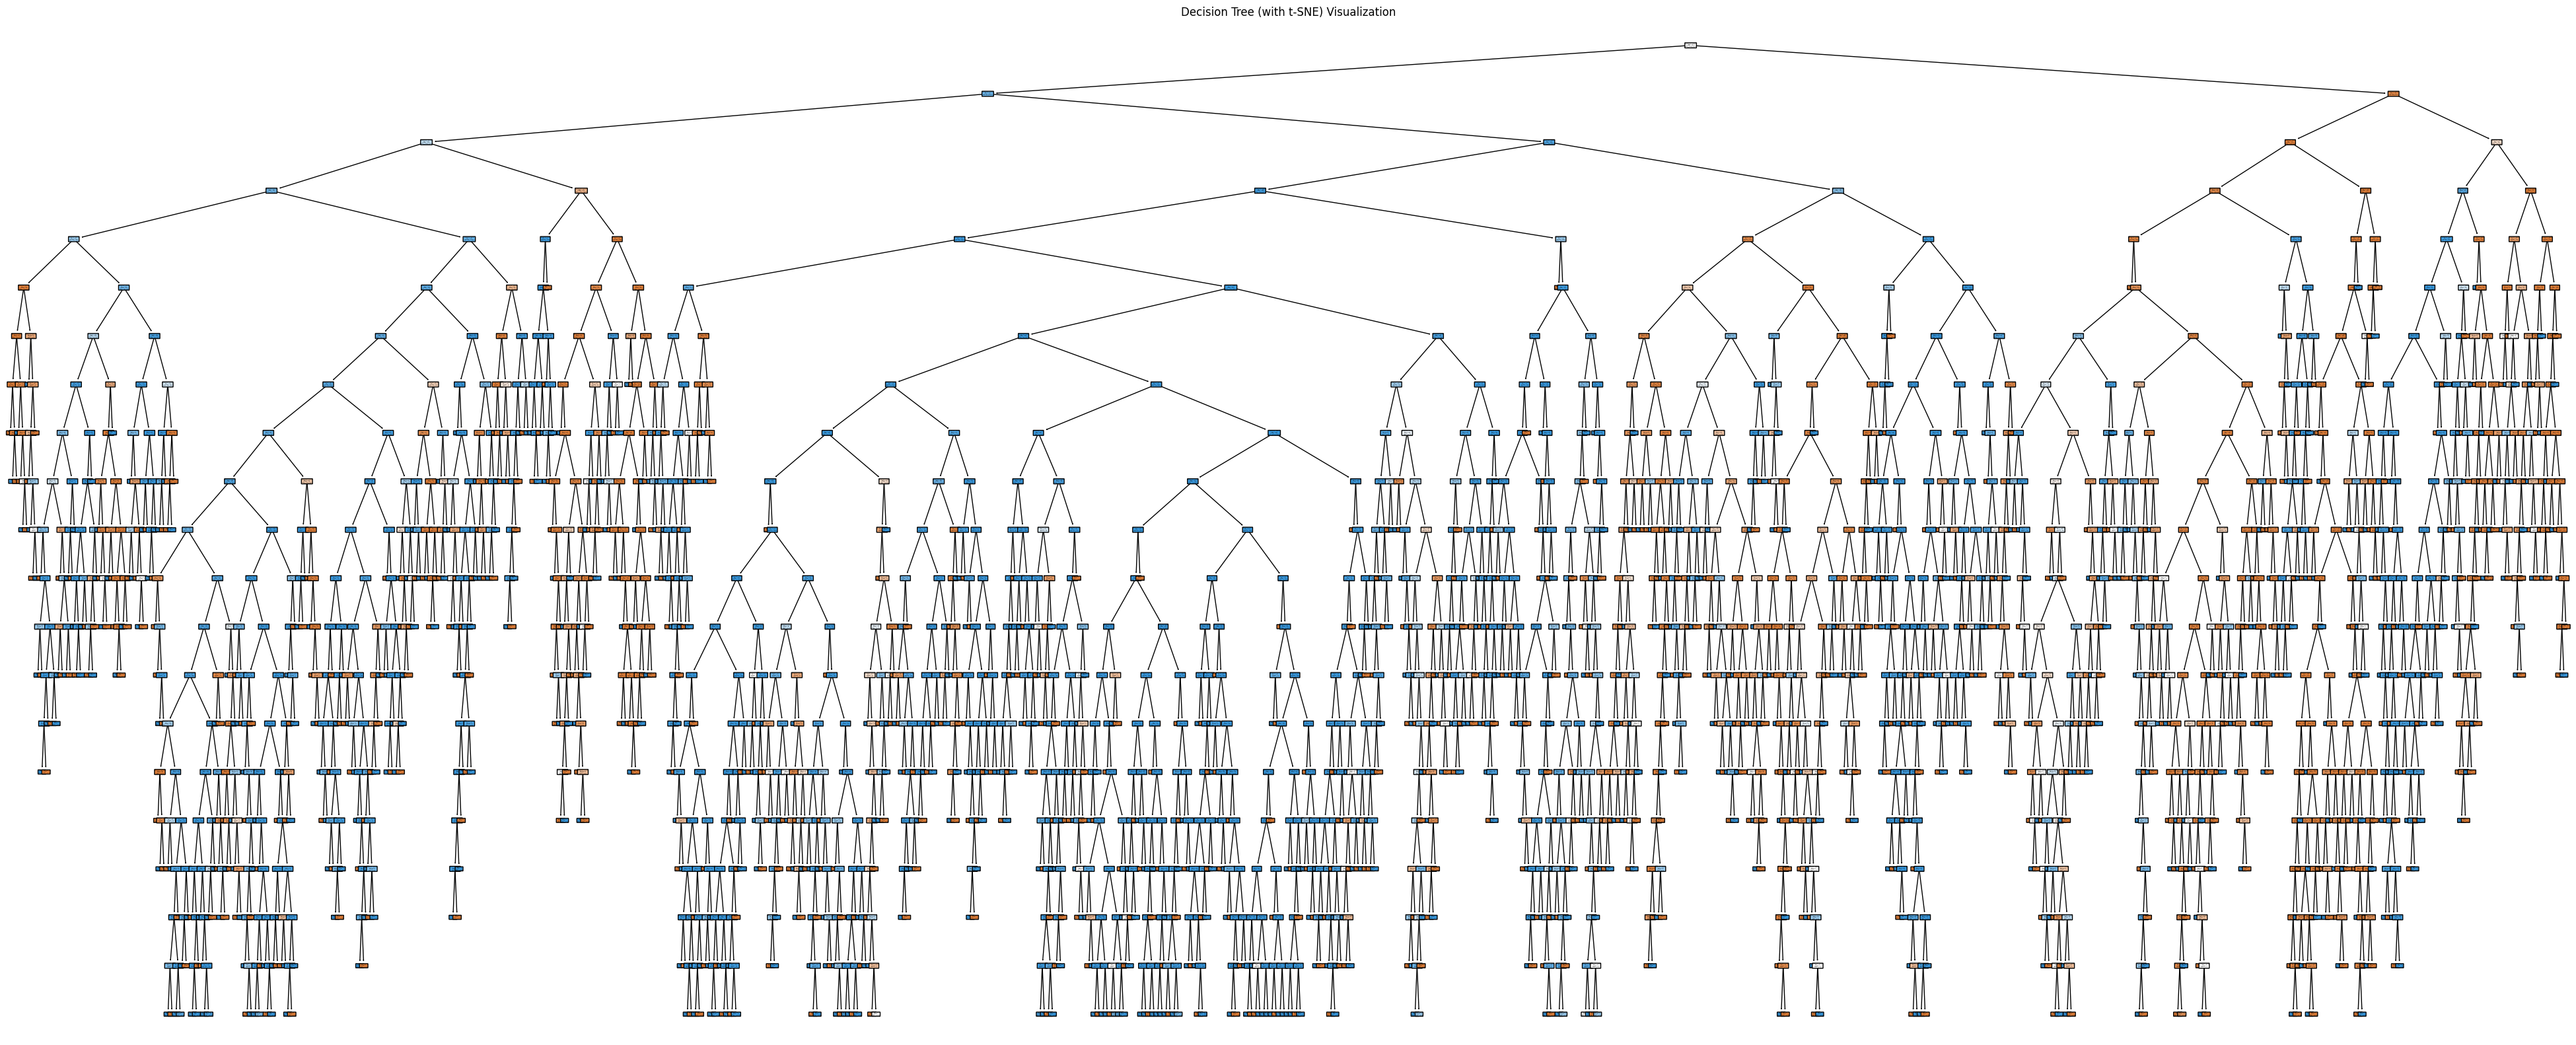

In [ ]:
print("WITH t-SNE:::")
print("DECISION TREE:")
tree_grid_search_tsne = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5, scoring='f1')
tree_grid_search_tsne.fit(X_train_tsne, y_train)
print(f"\n Best Params: {tree_grid_search_tsne.best_params_}\n")
evaluate_model(tree_grid_search_tsne.best_estimator_, X_train_tsne, X_test_tsne, y_train, y_test)

# Fit the best hyperparams from GridSearchCV to the data
best_tree_model = tree_grid_search_tsne.best_estimator_
# Plot the decision tree
plt.figure(figsize=(50, 20))
plot_tree(
    best_tree_model,
    feature_names=X_train_tsne.columns if hasattr(X_train_tsne, "columns") else [f"Feature {i}" for i in range(X_train_tsne.shape[1])],
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (with t-SNE) Visualization")
plt.show()

In [ ]:
print("WITH t-SNE:::")
print("RANDOM FOREST:")
rf_grid_search_tsne = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1')
rf_grid_search_tsne.fit(X_train_tsne, y_train)
print(f"\n Best Params: {rf_grid_search_tsne.best_params_}")
evaluate_model(rf_grid_search_tsne.best_estimator_, X_train_tsne, X_test_tsne, y_train, y_test)

print("\n")
# Extract one of the trees from the Random Forest model
best_rf_model = rf_grid_search_tsne.best_estimator_
single_tree = best_rf_model.estimators_[0]  # Get the first tree from the forest

# Plot the decision tree
plt.figure(figsize=(50, 20))
plot_tree(
    single_tree,
    feature_names=X_train_tsne.columns if hasattr(X_train_tsne, "columns") else [f"Feature {i}" for i in range(X_train_tsne.shape[1])],
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (from Random Forest with t-SNE) Visualization")
plt.show()

In [ ]:
print("WITH t-SNE:::")
print("SVM:")
svm_grid_search_tsne = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='f1')
svm_grid_search_tsne.fit(X_train_tsne, y_train)
print(f"\n Best Params: {svm_grid_search_tsne.best_params_}\n")
evaluate_model(svm_grid_search_tsne.best_estimator_, X_train_tsne, X_test_tsne, y_train, y_test)

- Binary Classification Models with Autoencoder Performance:

In [ ]:
print("WITH AUTOENCODER::: ")
print("LOGISTIC REGRESSION:")
lr_grid_search_autoencoder = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring='f1')
lr_grid_search_autoencoder.fit(X_train_autoencoded, y_train)
print(f"\n Best Params: {lr_grid_search_autoencoder.best_params_}\n")
evaluate_model(lr_grid_search_autoencoder.best_estimator_, X_train_autoencoded, X_test_autoencoded, y_train, y_test)

WITH AUTOENCODER::: 
LOGISTIC REGRESSION:


In [ ]:
print("WITH AUTOENCODER::: ")
print("DECISION TREE:")
tree_grid_search_autoencoder = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5, scoring='f1')
tree_grid_search_autoencoder.fit(X_train_autoencoded, y_train)
print(f"\n Best Params: {tree_grid_search_autoencoder.best_params_}\n")
evaluate_model(tree_grid_search_autoencoder.best_estimator_, X_train_autoencoded, X_test_autoencoded, y_train, y_test)

print("\n")
# Fit the best hyperparams from GridSearchCV to the data
best_tree_model = tree_grid_search_autoencoder.best_estimator_
# Plot the decision tree
plt.figure(figsize=(50, 20))
plot_tree(
    best_tree_model,
    feature_names=X_train_pca.columns if hasattr(X_train_autoencoded, "columns") else [f"Feature {i}" for i in range(X_train_autoencoded.shape[1])],
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (with Autoencoder) Visualization")
plt.show()

WITH AUTOENCODER::: 
RANDOM FOREST:

 Best Params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
TRAINING DATA PERFORMANCE:
  Accuracy: 0.9808
  Precision: 0.9716
  Recall: 0.9907
  F1 Score: 0.9811
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7177
           1       0.97      0.99      0.98      7223

    accuracy                           0.98     14400
   macro avg       0.98      0.98      0.98     14400
weighted avg       0.98      0.98      0.98     14400


TEST DATA PERFORMANCE:
  Accuracy: 0.9441
  Precision: 0.9223
  Recall: 0.9690
  F1 Score: 0.9451
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3109
           1       0.92      0.97      0.95      3063

    accuracy                           0.94      6172
   macro avg       0.95      0.94      0.94      6172
weighted avg       0.95      0.94      

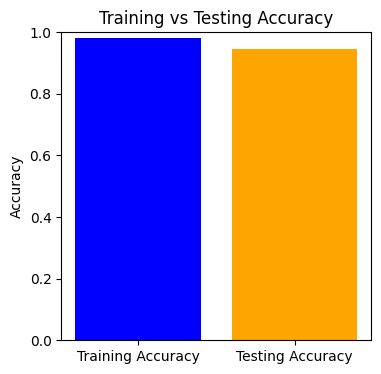

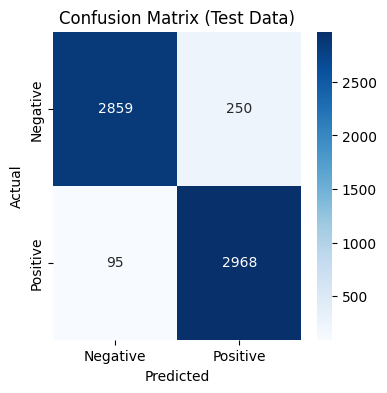


AUC (Test Data): 0.9837


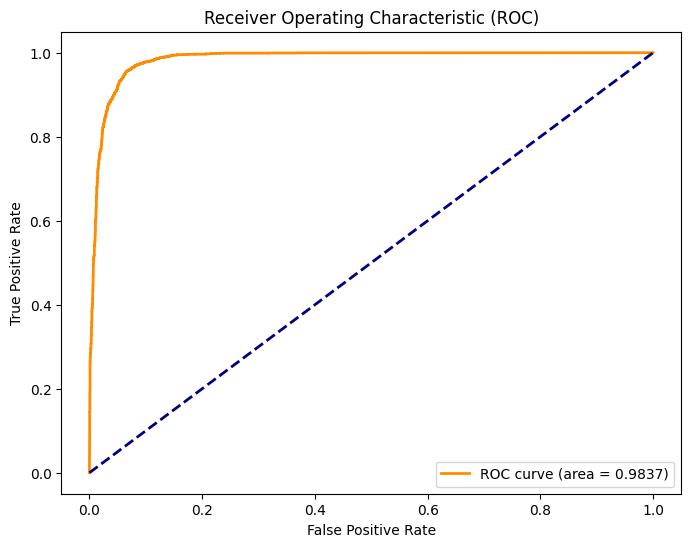

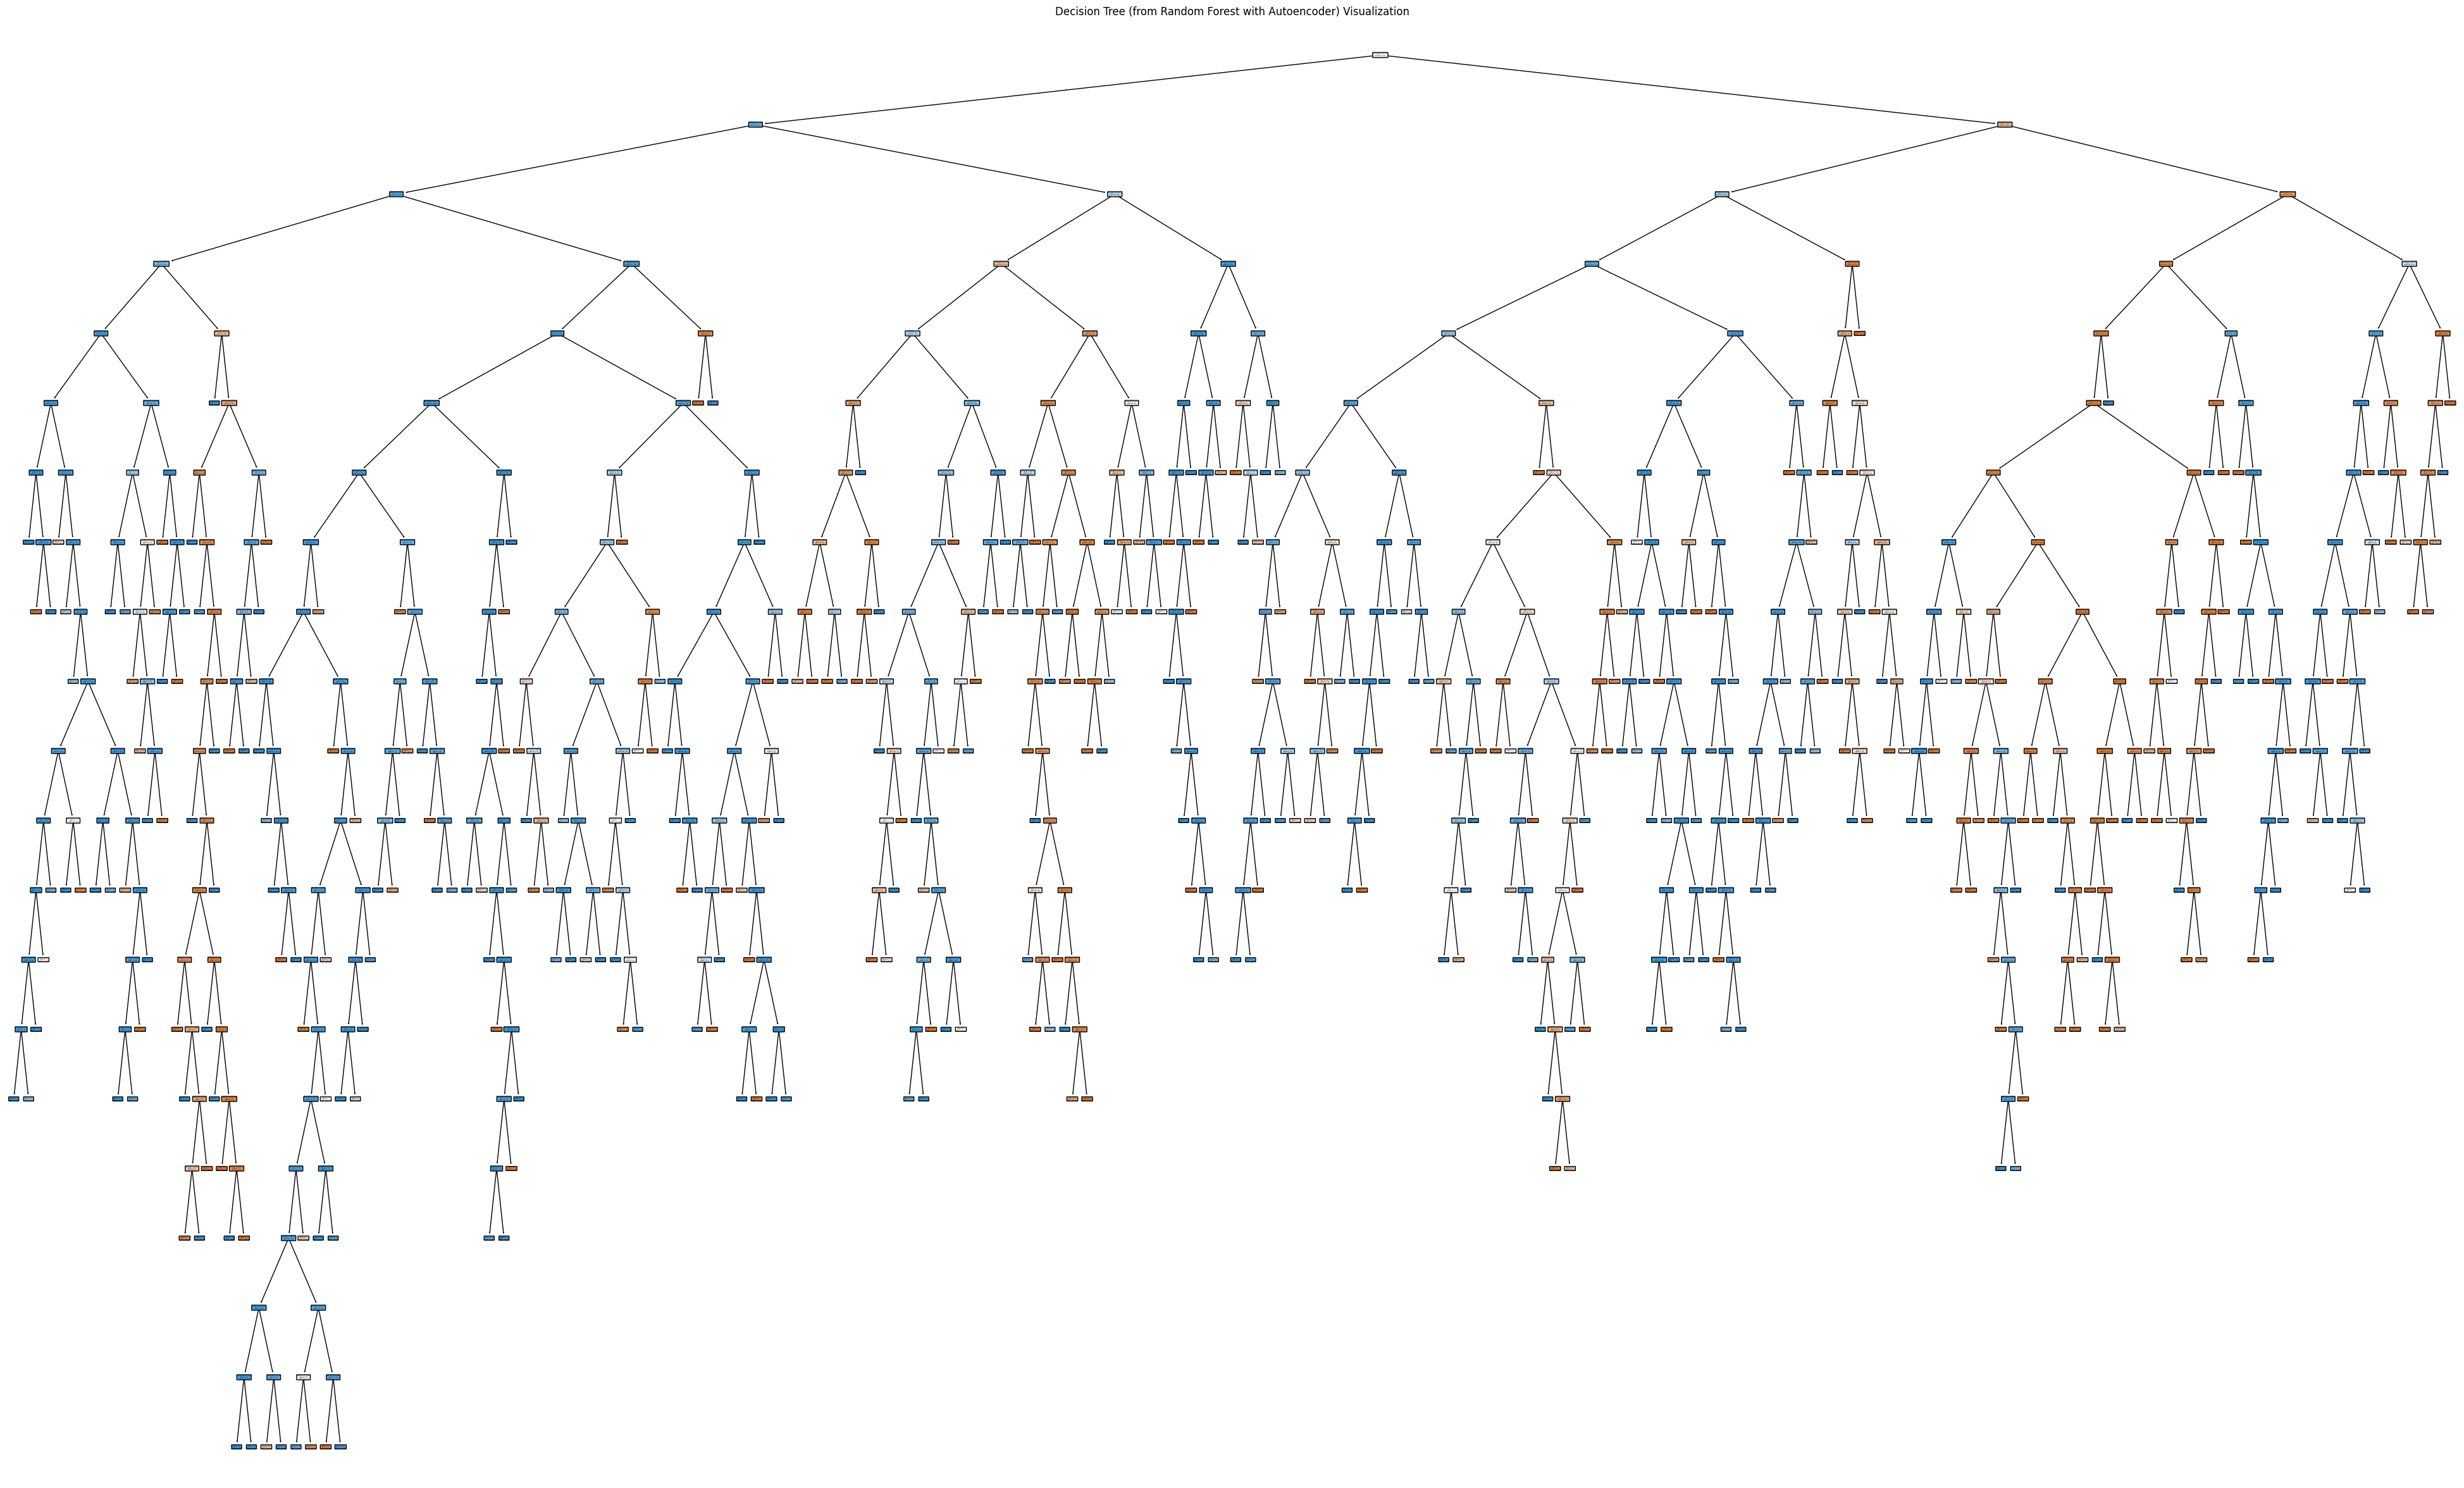

In [ ]:
print("WITH AUTOENCODER::: ")
print("RANDOM FOREST:")
rf_grid_search_autoencoder = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1')
rf_grid_search_autoencoder.fit(X_train_autoencoded, y_train)
print(f"\n Best Params: {rf_grid_search_autoencoder.best_params_}")
evaluate_model(rf_grid_search_autoencoder.best_estimator_, X_train_autoencoded, X_test_autoencoded, y_train, y_test)

print("\n")
# Extract one of the trees from the Random Forest model
best_rf_model = rf_grid_search_autoencoder.best_estimator_
single_tree = best_rf_model.estimators_[0]  # Get the first tree from the forest

# Plot the decision tree
plt.figure(figsize=(50, 20))
plot_tree(
    single_tree,
    feature_names=X_train_pca.columns if hasattr(X_train_autoencoded, "columns") else [f"Feature {i}" for i in range(X_train_autoencoded.shape[1])],
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (from Random Forest with Autoencoder) Visualization")
plt.show()

In [ ]:
print("WITH AUTOENCODER::: ")
print("SVM:")
svm_grid_search_autoencoder = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='f1')
svm_grid_search_autoencoder.fit(X_train_autoencoded, y_train)
print(f"\n Best Params: {svm_grid_search_autoencoder.best_params_}\n")
evaluate_model(svm_grid_search_autoencoder.best_estimator_, X_train_autoencoded, X_test_autoencoded, y_train, y_test)

##### Feed-Forward Neural Network with Autoencoder:
(using K-fold Cross-Validation)

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes),
            # Use Sigmoid for binary classification
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
# K-Fold Cross-Validation for FFNN
kf = KFold(n_splits=5, shuffle=True, random_state=42)
num_classes = len(y_train.unique())
train_accuracies, train_f1_scores, train_precisions, train_recalls = [], [], [], []
val_accuracies, val_f1_scores, val_precisions, val_recalls = [], [], [], []
roc_curves = []
confusion_matrices = []
num_epochs = 150

# Initialize lists to store test metrics
test_accuracies, test_f1_scores, test_precisions, test_recalls = [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_autoencoded)):
    X_train_fold, X_val_fold = X_train_autoencoded[train_index], X_train_autoencoded[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

    # Convert data to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_fold_tensor = torch.tensor(y_train_fold, dtype=torch.long).to(device).squeeze()
    X_val_fold_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_fold_tensor = torch.tensor(y_val_fold, dtype=torch.long).to(device).squeeze()

    # Initialize model, loss function, and optimizer
    model = FeedForwardNN(input_dim=X_train_autoencoded.shape[1], num_classes=num_classes).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_fold_tensor)
        loss = criterion(outputs[:, 1], y_train_fold_tensor.float())
        loss.backward()
        optimizer.step()

    # Calculate metrics
    model.eval() # Validation evaluation
    with torch.no_grad():
        # Training predictions
        y_train_pred_logits = model(X_train_fold_tensor)
        y_train_pred = torch.argmax(y_train_pred_logits, dim=1)
        # Validation predictions
        y_val_pred_logits = model(X_val_fold_tensor)
        y_val_pred = torch.argmax(y_val_pred_logits, dim=1)

        # Calculate metrics for training data
        train_accuracy = accuracy_score(y_train_fold, y_train_pred.cpu().numpy())
        train_f1 = f1_score(y_train_fold, y_train_pred.cpu().numpy(), average="weighted")
        train_precision = precision_score(y_train_fold, y_train_pred.cpu().numpy(), average="weighted")
        train_recall = recall_score(y_train_fold, y_train_pred.cpu().numpy(), average="weighted")
        # Append training metrics
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)

        # Calculate metrics for validation data
        val_accuracy = accuracy_score(y_val_fold, y_val_pred.cpu().numpy())
        val_f1 = f1_score(y_val_fold, y_val_pred.cpu().numpy(), average="weighted")
        val_precision = precision_score(y_val_fold, y_val_pred.cpu().numpy(), average="weighted")
        val_recall = recall_score(y_val_fold, y_val_pred.cpu().numpy(), average="weighted")
        # Append validation metrics
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(y_val_fold, y_val_pred_logits[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_curves.append((fpr, tpr, roc_auc))
        # Confusion Matrix
        cm = confusion_matrix(y_val_fold, y_val_pred)
        confusion_matrices.append(cm)

# Calculate average metrics across folds
avg_train_accuracy = np.mean(train_accuracies)
avg_train_f1 = np.mean(train_f1_scores)
avg_train_precision = np.mean(train_precisions)
avg_train_recall = np.mean(train_recalls)

avg_val_accuracy = np.mean(val_accuracies)
avg_val_f1 = np.mean(val_f1_scores)
avg_val_precision = np.mean(val_precisions)
avg_val_recall = np.mean(val_recalls)

print("\n TRAINING METRICS:")
print(f"Average Accuracy: {avg_train_accuracy:.4f}")
print("Fold Accuracies:", train_accuracies)
print(f"Average F1 Score: {avg_train_f1:.4f}")
print(f"Average Precision: {avg_train_precision:.4f}")
print(f"Average Recall: {avg_train_recall:.4f}")

print("\n\n VALIDATION METRICS:")
print(f"Average Accuracy: {avg_val_accuracy:.4f}")
print("Fold Accuracies:", val_accuracies)
print(f"Average F1 Score: {avg_val_f1:.4f}")
print(f"Average Precision: {avg_val_precision:.4f}")
print(f"Average Recall: {avg_val_recall:.4f}\n")

# Plot ROC curves for all folds
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f"Fold {i + 1} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Cross-Validation Folds")
plt.legend(loc="lower right")
plt.show()

# Average confusion matrix across folds
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
print(f"\n\nAverage Confusion Matrix: \n{avg_confusion_matrix}\n")

# Plot average confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(avg_confusion_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Average Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Testing data Metrics Calculation
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_autoencoded, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device).squeeze()

# Initialize model for testing
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Test predictions
    y_test_pred_logits = model(X_test_tensor)
    y_test_pred_probs = torch.softmax(y_test_pred_logits, dim=1)[:, 1].cpu().numpy()
    y_test_pred = torch.argmax(y_test_pred_logits, dim=1)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred.cpu().numpy())
    test_f1 = f1_score(y_test, y_test_pred.cpu().numpy(), average="weighted")
    test_precision = precision_score(y_test, y_test_pred.cpu().numpy(), average="weighted")
    test_recall = recall_score(y_test, y_test_pred.cpu().numpy(), average="weighted")
    # Append test metrics
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)

# Calculate average testing metrics
avg_test_accuracy = np.mean(test_accuracies)
avg_test_f1 = np.mean(test_f1_scores)
avg_test_precision = np.mean(test_precisions)
avg_test_recall = np.mean(test_recalls)

print("\n\n TESTING METRICS:")
print(f"Average Accuracy: {avg_test_accuracy:.4f}")
print(f"Average F1 Score: {avg_test_f1:.4f}")
print(f"Average Precision: {avg_test_precision:.4f}")
print(f"Average Recall: {avg_test_recall:.4f}\n")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Test Data")
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n\n Confusion Matrix: \n{avg_confusion_matrix}\n")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##### Feature Importance Extraction:

In [ ]:
# Function to extract and display top features
def get_top_features(model, X_encoded, top_n=30):
    # Extract feature importances
    feature_importances = model.feature_importances_
    feature_names = X_encoded.columns
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    # Sort features by importance
    top_features = importances_df.sort_values(by='Importance', ascending=False).head(top_n)
    return top_features

In [ ]:
# Extract top 30 features from Random Forest model
print("\nTop 30 Features from Random Forest:")
top_features_rf = get_top_features(best_rf_model, X_test_encoded, top_n=30)
print(top_features_rf)

In [ ]:
# Extract top 30 features from Decision Tree model
print("\nTop 30 Features from Decision Tree:")
top_features_tree = get_top_features(best_tree_model, X_test_encoded, top_n=30)
print(top_features_tree)

In [ ]:
# Feature Importance (RF)
best_rf_model = rf_grid_search_autoencoder.best_estimator_
feature_importances = best_rf_model.feature_importances_
rf_feature_names = encoder.get_feature_names_out()
rf_imp_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': feature_importances})
# Sort by importance and select the top features
top_features_rf = rf_imp_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(top_features_rf)
# Sort by importance and select the top 30 features
top_30features_rf = rf_imp_df.sort_values(by='Importance', ascending=False).head(30)
print(f"The top 30 features:\n", top_30features_rf)

# Feature Importance (DT)
best_tree_model = tree_grid_search_autoencoder.best_estimator_
feature_importances = best_tree_model.feature_importances_
dt_feature_names = encoder.get_feature_names_out()
importances_df = pd.DataFrame({'Feature': dt_feature_names, 'Importance': feature_importances})
# Sort by importance and display top features
top_features_tree = importances_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(top_features_tree)